# EEG Feature Extraction 3: Feature Selection based on Mutual Information 

In 2008, a BCI Competition was held on EEG datasets to find the best ML and statistical algorithms to differentiate different classes of neural data. The BCI Competition IV 2b is a motor imagery dataset with eye artifact data, making it a very realistic dataset. The subjects are prompted to imagine left vs right hand movement and the EEG + EOG signals for each trial are collected. We here have provided a simpler version of the dataset in CSV format for you to get started with. 

This notebook will introduce a couple more feature extraction methods, provide some guidance in dimensionality reduction, and show how these features can be used in a model to predict classes. 

Terminology: <br>
- <b>Common Spatial Pattern (CSP)</b>: A kernel used as a supervised decomposition to estimate spatial filters for feature extraction.
- <b>Mutual Information (MI)</b>: Calculated value between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.


More details on the experiment can be found here: http://www.bbci.de/competition/iv/desc_2b.pdf  <br>
Data can be downloaded on Kaggles: https://www.kaggle.com/c/ucsd-neural-data-challenge
<br>
CSP: https://mne.tools/0.11/generated/mne.decoding.CSP.html#mne.decoding.CSP <br>
MI: https://machinelearningmastery.com/information-gain-and-mutual-information/ 
<br>
EEGNet: 
https://colab.research.google.com/drive/1-8vH_UGvIy6ql2ky5lRn-_-Lkp2TuzIG


# Imports

In [1]:
from pathlib import Path # For making paths compatible on Windows and Macs
import time
import sys
sys.setrecursionlimit(10000)
from matplotlib import rcParams
import os
import seaborn as sns

# processing data 
!pip install neurodsp
!pip install git+https://github.com/forrestbao/pyeeg.git
import pickle # For loading and creating pickle files
import pandas as pd # For working with DataFrames 
import numpy as np # For ease of array manipulation, stats, and some feature extraction
import matplotlib.pyplot as plt # For plotting pretty plots :) 
import scipy.signal as signal # For calculating PSDs and plotting spectrograms
import pyeeg # For pyeeg implemented features
from neurodsp.spectral import compute_spectrum, compute_scv # for smoothed PSD computation
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time # For neurodsp features
from neurodsp.filt import filter_signal_fir
from neurodsp.rhythm import compute_lagged_coherence
from tensorflow.keras.utils import normalize
!pip install mne
from mne.decoding import CSP
from sklearn import preprocessing

# for data-analysis 
from statistics import mean, stdev, variance  # alternatively from numpy import mean, std
from sklearn.feature_selection import mutual_info_classif

# for modeling
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
import tensorflow as tf
import keras

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from mne.decoding import SPoC
from mne.preprocessing import ICA

# for saving model and loading model
import joblib
from tensorflow.keras.models import load_model
import glob

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-86fjb957
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-86fjb957
     |████████████████████████████████| 6.9 MB 6.6 MB/s 


# Load Data
Loading compeititon data from Kaggles, custom feature extraction files from Github

*   [Mount Google Drive](https://colab.research.google.com/notebooks/io.ipynb) </br>
*   [Structure Colab Project](https://neptune.ai/blog/google-colab-dealing-with-files)
*   [Git LFS](https://stackoverflow.com/questions/54451856/how-can-i-tell-if-a-file-will-begrrectly)
*   [Git Detached Head State](https://www.cloudbees.com/blog/git-detached-head)
*   [Download data from Kaggles on Colab](https://www.kaggle.com/c/ucsd-neural-data-challenge/data)
*   [Git revision control](https://colab.research.google.com/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-7-Revision-Control-Software.ipynb#scrollTo=-IHQFz4C0Fav)<br>



Download LFS package

In [2]:
# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
# !sudo apt-get install git-lfs

Retrieve non-LFS & LFS files (.pkl & .csv) from pointers. This might take a few minutes since the size of the data set is 3 GB.

In [3]:
# !git clone https://github.com/chawei217/Neuro-Data-Competition.git

Navigate directories under Neuro-Data-Competition

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd '/content/gdrive/MyDrive/Neural Data Competition'

/content/gdrive/MyDrive/Neural Data Competition


# Constants

Load epoched data

In [160]:
# These are the epochs that will be used in accuracy evaluation
epoch_df_filename1 = Path("./data/epoched_train1.pkl")
eeg_epoch_full_df1 = pd.read_pickle(epoch_df_filename1)
epoch_df_filename2 = Path("./data/epoched_train2.pkl")
eeg_epoch_full_df2 = pd.read_pickle(epoch_df_filename2)
eeg_epoch_full_df = pd.concat([eeg_epoch_full_df1, eeg_epoch_full_df2], axis=0)

In [59]:
eeg_fs = 250 # Data was recorded at 250 Hz
eeg_chans = ["C3", "Cz", "C4"] # 10-20 system 
eog_chans = ["EOG:ch01", "EOG:ch02", "EOG:ch03"] 
filters = ["fir", "psd", "lag", "scv", "amp", "pha", "i_f"]
all_chans = eeg_chans + eog_chans
event_types = {"left":0, "right":1}
y = np.array(eeg_epoch_full_df["event_type"].values.tolist())
X = eeg_epoch_full_df[all_chans].values.tolist()
X = np.array(X)
plt.style.use('ggplot')

In [8]:
assert np.isclose(X[0, 0, 0], eeg_epoch_full_df.loc[0, 'C3'][0], atol=0.0001)
y.shape, X.shape

((3680,), (3680, 6, 1000))

Parse into MNE array



In [60]:
X_mne = X[:, 0:4, :]
X_mne.shape
heog = X[:, 3, :] - X[:, 5, :]
X_mne[:, 3, :] = heog
X_mne.shape

(3680, 4, 1000)

In [61]:
montage = mne.channels.make_standard_montage('standard_1005')
info = mne.create_info(ch_names=eeg_chans + ['heog'], sfreq=eeg_fs, ch_types=['eeg', 'eeg', 'eeg', 'eog'])

In [62]:
epochs = mne.EpochsArray(X_mne.copy() * 10e-6, info=info)  # convert to volts
epochs.set_montage(montage)
epochs.apply_baseline((None, None))
picks = mne.pick_types(info, eeg=True, eog=True)

Not setting metadata
Not setting metadata
3680 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Applying baseline correction (mode: mean)


In [12]:
X_mne = np.transpose(epochs.copy(), [1, 0, 2]).reshape([X_mne.shape[1], -1])  
X_mne.shape

(4, 3680000)

In [13]:
raw = mne.io.RawArray(X_mne, info, copy='both')

Creating RawArray with float64 data, n_channels=4, n_times=3680000
    Range : 0 ... 3679999 =      0.000 ... 14719.996 secs
Ready.


Observe the raw data

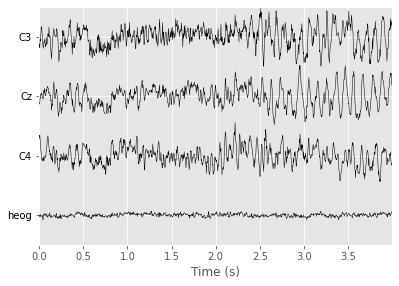

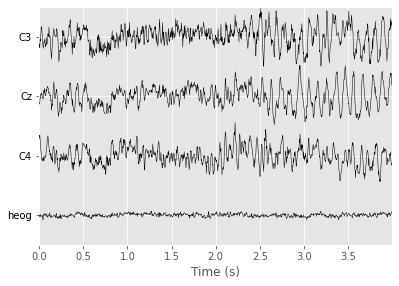

In [14]:
raw.plot(start=0, duration=4, scalings=dict(eeg=1e-4, eog=10e-4), show_scrollbars=False, show_scalebars=False)

Remove artifact with regression

In [17]:
# do regression
_, betas = mne.preprocessing.regress_artifact(epochs.copy().subtract_evoked())
epochs_clean, _ = mne.preprocessing.regress_artifact(epochs, betas=betas)

Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: heog
[done]


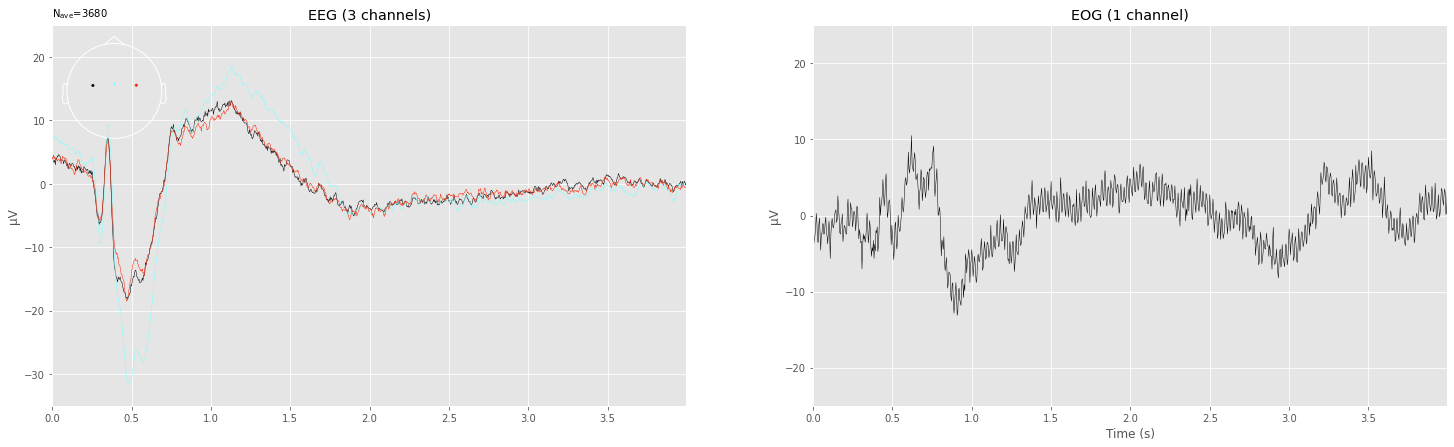

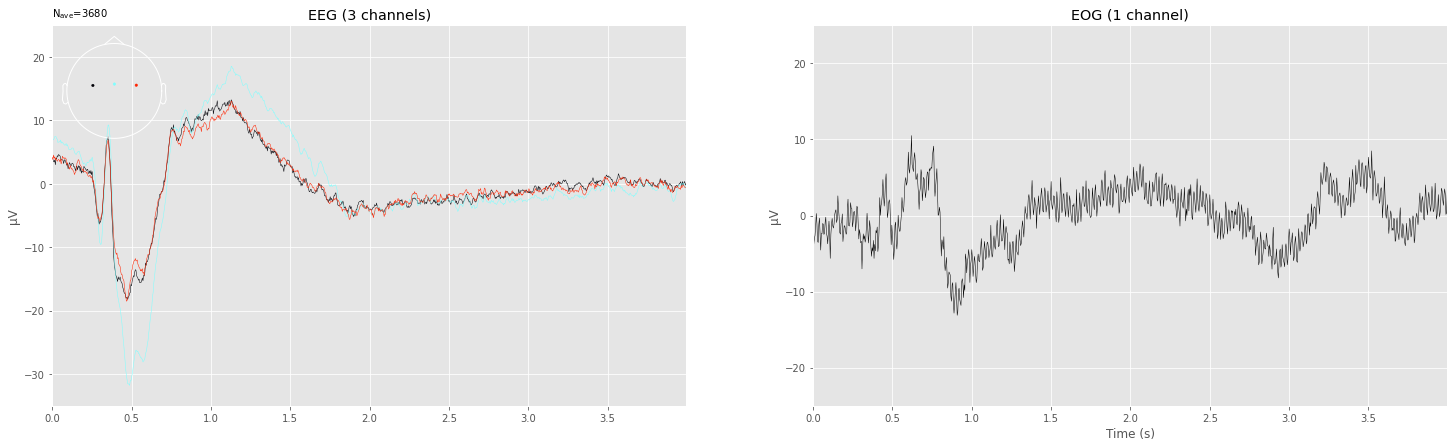

In [18]:
fig, ax1 = plt.subplots(ncols=2, nrows=1, figsize=(25,7))
# for ax in ax1:
#   ax.set_prop_cycle(color=['red', 'green', 'blue'])
plot_picks = ['eeg', 'eog']
evo_kwargs = dict(picks=plot_picks, spatial_colors=True,
                  verbose='error')  # ignore warnings about spatial colors
evo_kwargs['ylim'] = dict(eeg=[-35, 25], eog=[-25, 25])
fig = epochs.average(picks=plot_picks).plot(axes=ax1, **evo_kwargs);

fig, (ax2) = plt.subplots(ncols=2, nrows=1, figsize=(25, 7))
# plot regressed data
fig = epochs_clean.average(picks=plot_picks).plot(axes=ax2, **evo_kwargs);

Using EOG channel: heog
EOG channel index for this subject is: [3]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 146 significant peaks
Number of EOG events detected: 146


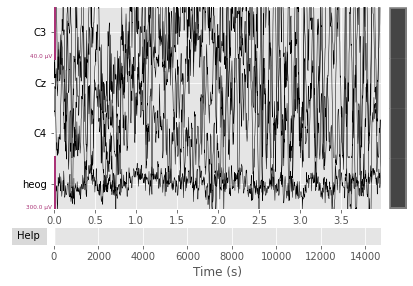

In [19]:
eog_events = mne.preprocessing.find_eog_events(raw)
raw.plot(events=eog_events, start=0, duration=4);

Reject trials by thresholding

In [75]:
reject_criteria = dict(
                       eeg=100,       # 100 µV
                       eog=450)       # 450 µV

In [76]:
epochs = mne.EpochsArray(X_mne.copy(), info=info, reject=reject_criteria, verbose=1)
epochs.set_montage(montage)
picks = mne.pick_types(info, eeg=True, eog=True)
nave = len(epochs)  # Number of averaged epochs

Not setting metadata
Not setting metadata
3680 matching events found
No baseline correction applied
0 projection items activated
    Rejecting  epoch based on EOG : ['heog']
    Rejecting  epoch based on EOG : ['heog']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'C4']
    Rejecting  epoch based on EOG : ['heog']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C3', 'C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EOG : ['heog']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG 

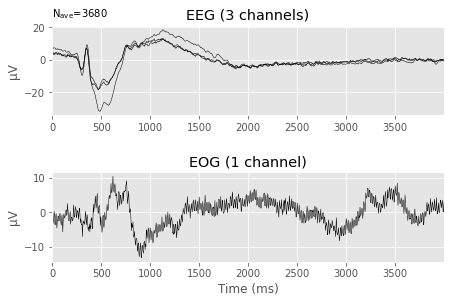

In [23]:
evoked_data = np.mean(epochs, axis=0)
evokeds = mne.EvokedArray(evoked_data, info=info, 
                          comment='Arbitrary', nave=nave)
evokeds.plot(picks=picks, time_unit='ms');

Bandpass 8 - 30 Hz

Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 sec)



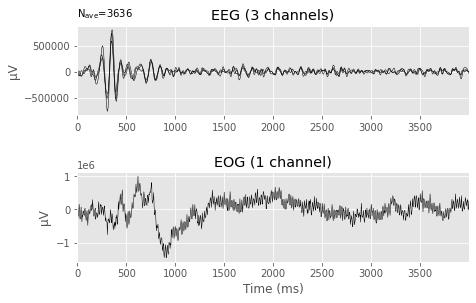

In [77]:
filt_raw = epochs.copy()
filt_raw.load_data().filter(l_freq=8, h_freq=30)
evokeds_filter = np.mean(filt_raw, axis=0)
evokeds_filter = mne.EvokedArray(evokeds_filter, info=info, 
                          comment='Arbitrary', nave=nave)
evokeds_filter.plot(picks=picks, time_unit='ms');

ICA on the bandpassed data

In [78]:
raw_copy = epochs.copy()
ica = ICA(n_components=3, max_iter='auto', random_state=97)
ica.fit(raw_copy) 
results = ica.apply(raw_copy) # inplace change

Fitting ICA to data using 3 channels (please be patient, this may take a while)


<ipython-input-78-5d3b44df1bd5>:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_copy)


Selecting by number: 3 components
Fitting ICA took 3.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (3 components)
    Zeroing out 0 ICA components
    Projecting back using 3 PCA components


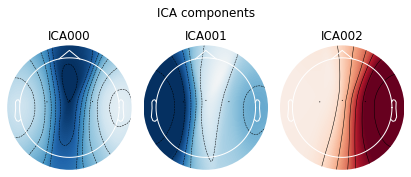

[<MNEFigure size 421.2x187.56 with 3 Axes>]

In [79]:
ica.plot_components(outlines="skirt")

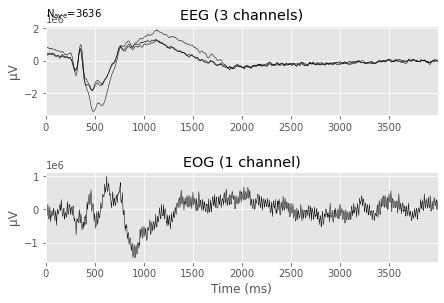

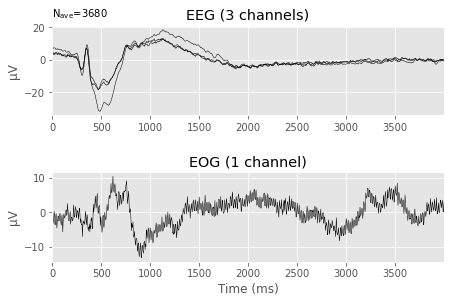

In [80]:
evoked_filter = np.mean(results, axis=0)
evokeds_filter = mne.EvokedArray(evoked_filter, info=info, 
                          comment='Arbitrary', nave=nave)
evokeds_filter.plot(time_unit='ms');
evokeds.plot(picks=picks, time_unit='ms');

# Helper functions

In [81]:
# Multiple bar graph plotting
def plotMultipleBarGraphs(bars, bar_width, bar_names, group_names, error_values=None, title=None, xlabel=None, ylabel=None): 
    if len(bar_names) != len(bars):
        print("bar names must be same length as bars")
        return 
    # Set position of bar on X axis
    positions = list()
    positions.append(np.arange(len(bars[0])))
    for i, bar in enumerate(bars): 
        if i>0: 
            positions.append([x + bar_width for x in positions[i-1]])

    # Make the plot
    for i, pos in enumerate(positions):
        plt.bar(pos, bars[i], width=bar_width, label=bar_names[i])
    
    if error_values is not None: 
        for i, pos in enumerate(positions):
            plt.errorbar(pos, bars[i], yerr=error_values[i], fmt='.k')
    
    # Add xticks on the middle of the group bars
    if xlabel: 
        plt.xlabel(xlabel)
    if ylabel: 
        plt.ylabel(ylabel)
    if title: 
        plt.title(title)
    plt.xticks([r + bar_width for r in range(len(bars[0]))], group_names)

    # Create legend & Show graphic
    plt.legend()
    plt.show()

# Data Visualization

## Visualize the right-hand versus left-hand motor imagery

Define f_range for bandpassing

In [82]:
f_range = (8, 30)

Helper Functions

In [83]:
def plot_avg_signals(right_data, left_data, xlabel='timepoint', ylabel='uV'):
  fig, axs = plt.subplots(right_data_avg.shape[0], figsize=(15,15))
  for chan in range(0, right_data_avg.shape[0]):
    axs[chan].set_title(all_chans[chan])
    axs[chan].plot(right_data[chan, :])
    axs[chan].plot(left_data[chan, :])
    axs[chan].legend([event for (idx, event) in event_types.items()], loc='upper right')
    axs[chan].set(xlabel=xlabel, ylabel=ylabel)
  for ax in axs:
    ax.label_outer()

Split data based on right v.s. left hand imaginary motor imagery


In [84]:
left_data = eeg_epoch_full_df[eeg_epoch_full_df["event_type"] == 0]
right_data = eeg_epoch_full_df[eeg_epoch_full_df["event_type"] == 1]
left_data = left_data[all_chans]
right_data = right_data[all_chans]
display(left_data.head(2))
display(right_data.head(2))

,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
0,"[-3.6285954070344086, -2.337682154573892, -3.6...","[-2.920576791027695, -2.47501335164416, -2.548...","[5.502403295948728, 6.485084306095978, 6.68955...","[7.354848554207674, 4.699778744182498, 8.39246...","[5.676356145571068, 10.2235446707866, 16.08300...","[9.857328145265887, 4.303044174868391, 15.5336..."
2,"[-0.2380407415884641, -2.0721751735713743, -2....","[2.825970855268177, 3.308155947203784, 1.83718...","[-0.9155413138017852, -0.5645838101777675, -2....","[-8.331425955596247, -15.7778286411841, -1.922...","[-1.9226367589837492, -9.552147707331956, -6.6...","[-8.453498130769818, -15.228503852903028, -7.1..."


,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
1,"[2.9480430304417484, -0.05493247882810711, 0.3...","[4.437323567559321, 2.4872205691615163, 0.9674...","[1.3855191882200348, -0.4699778744182498, 0.44...","[-18.127718013275352, 18.188754100862134, -5.8...","[-14.373998626688028, 21.484702830548557, -6.2...","[-11.9325551232166, 20.202944991226055, -9.613..."
3,"[-0.5554283970397498, -2.926680399786373, -4.9...","[5.743495841916532, 4.785229266803998, 3.40581...","[0.9155413138017852, 1.541161211566339, 1.0284...","[6.6224155031662475, 3.1128404669260696, 11.74...","[-1.6174563210498203, -2.349889372091249, 9.00...","[-2.2278171969176768, 2.349889372091249, 12.90..."


In [85]:
left_data = np.array(left_data.values.tolist())
right_data = np.array(right_data.values.tolist())
left_data_avg = np.mean(left_data, axis=0)
right_data_avg = np.mean(right_data, axis=0)
left_data.shape, right_data.shape

((1840, 6, 1000), (1840, 6, 1000))

### Raw singals - average of all trials

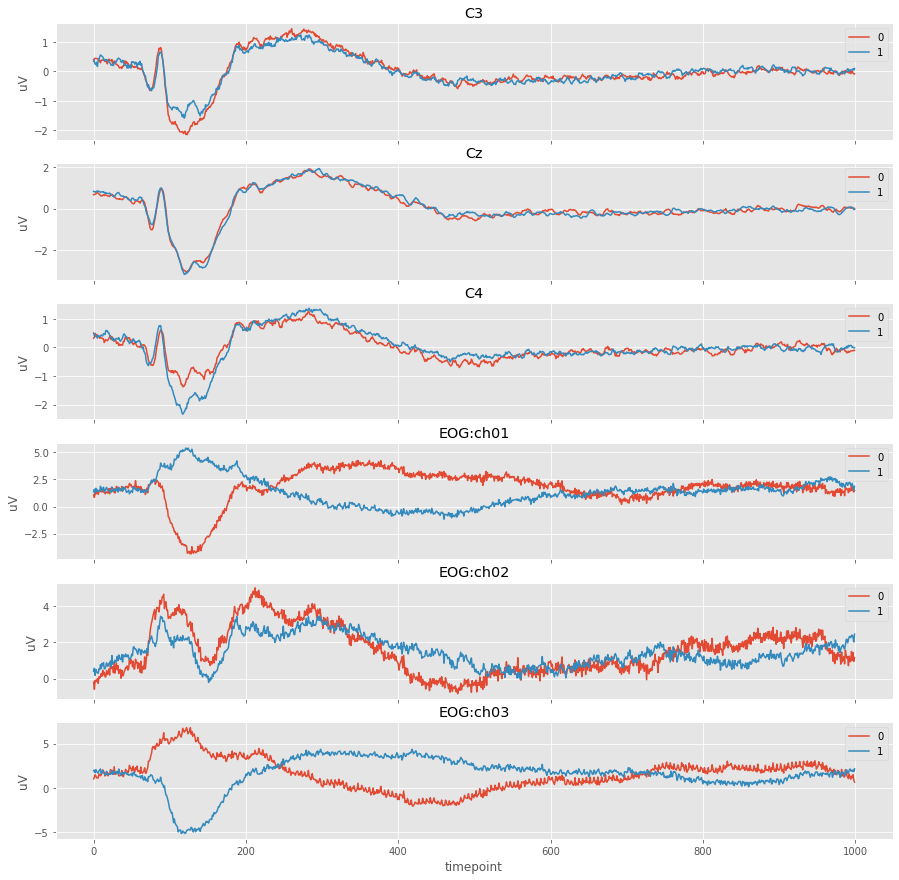

In [86]:
plot_avg_signals(right_data_avg, left_data_avg, ylabel='uV')

### Amplitude by time (instantaneous amplitude) - average of all trials
This is defined as the power of the provided frequency band at a particular point in time. Frequency range is [8, 30] to give better classificaiton results compared to narrow bands: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=895946

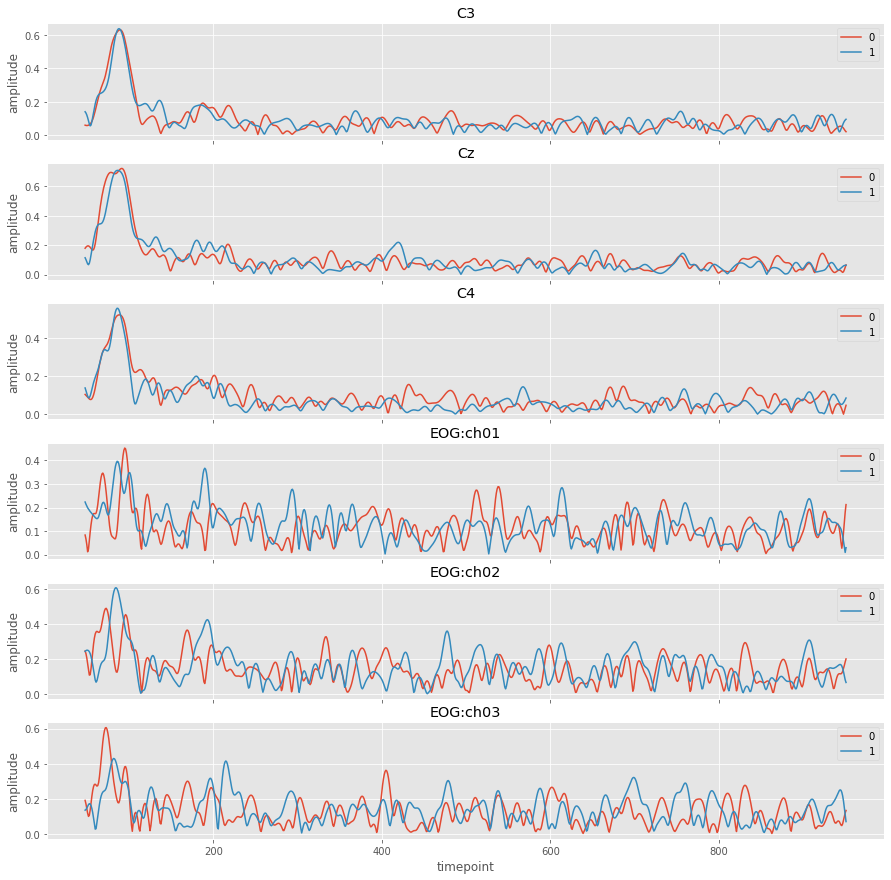

In [87]:
left_amp_avg = amp_by_time(left_data_avg, eeg_fs, f_range)
right_amp_avg = amp_by_time(right_data_avg, eeg_fs, f_range)
plot_avg_signals(right_amp_avg, left_amp_avg, ylabel='amplitude')

Compare amp_by_time signals with the raw signals

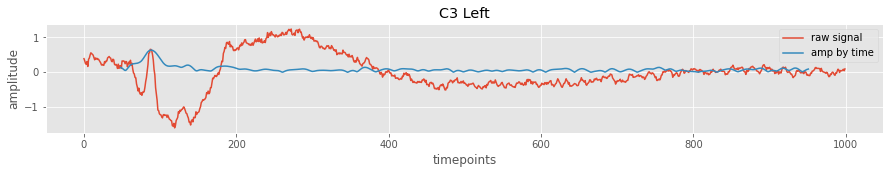

In [88]:
chan = 0
plt.figure(figsize=(15, 2))
plt.title(all_chans[chan] + " Left")
plt.plot(left_data_avg[chan])
plt.plot(left_amp_avg[chan])
plt.ylabel('amplitude')
plt.xlabel('timepoints')
plt.legend(['raw signal', 'amp by time']);

### Phase by time (instantaneous phase) - average of all trials
This is defined as the phase of the signal over time. Phase is the angle of the sine wave that is represented by the frequency range.

In [89]:
# Calculate and plot alpha amplitude over time
left_phase_avg = phase_by_time(left_data_avg, eeg_fs, f_range)
right_phase_avg = phase_by_time(right_data_avg, eeg_fs, f_range)

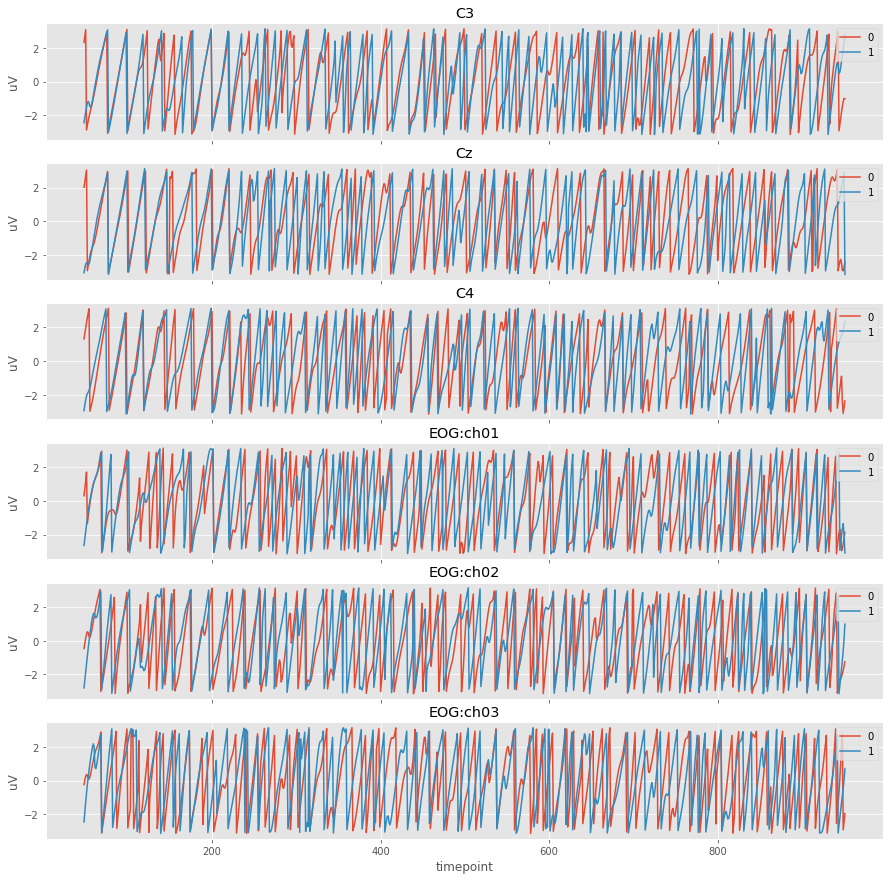

In [90]:
plot_avg_signals(right_phase_avg, left_phase_avg)

Compare phase_by_time signals with the raw signals

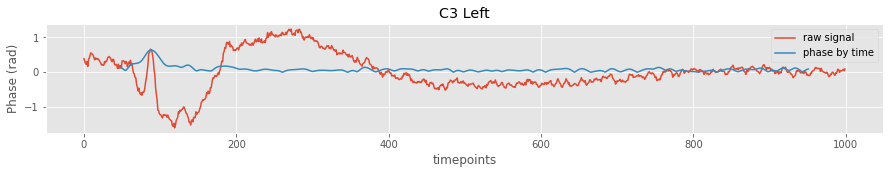

In [91]:
chan = 0
plt.figure(figsize=(15, 2))
plt.title(all_chans[chan] + " Left")
plt.plot(left_data_avg[chan])
plt.plot(left_amp_avg[chan])
plt.ylabel('Phase (rad)')
plt.xlabel('timepoints')
plt.legend(['raw signal', 'phase by time']);

### Frequency by time (instantaneous frequency) - average of all trials
Instantaneous frequency is a measure of frequency across time.
It is measured as the temporal derivative of the instantaneous phase.

In [92]:
left_freq_avg = freq_by_time(left_data_avg, eeg_fs, f_range)
right_freq_avg = freq_by_time(right_data_avg, eeg_fs, f_range)

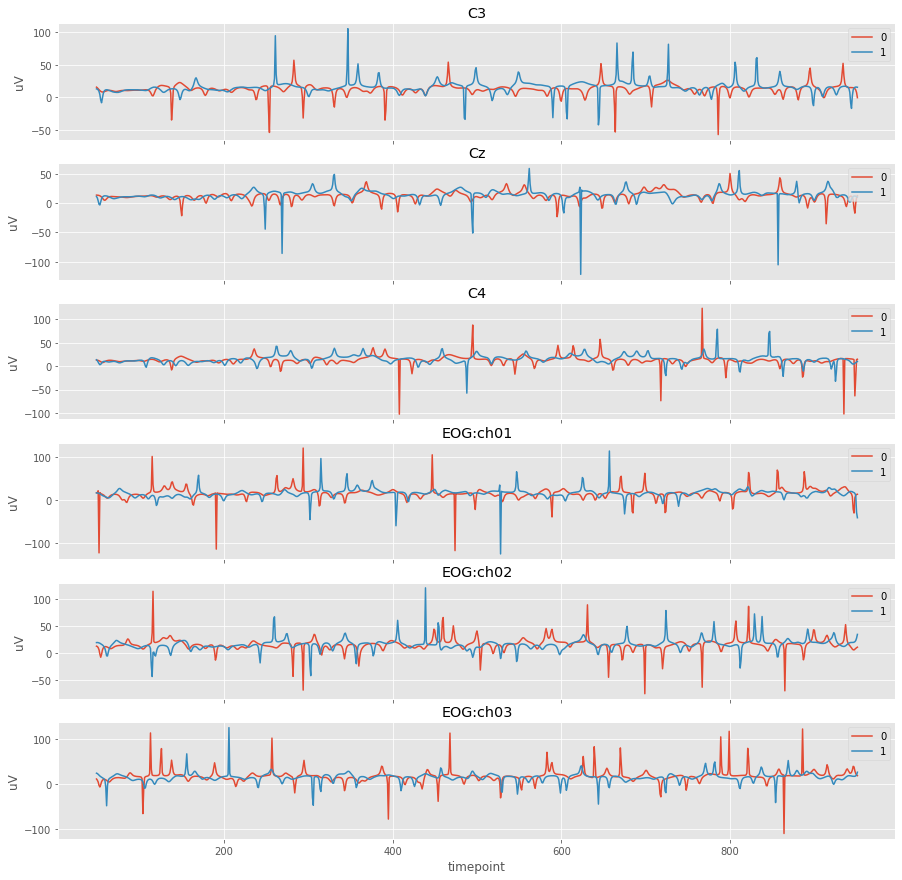

In [93]:
plot_avg_signals(right_freq_avg, left_freq_avg)

### FIR - average of all trials
Zero-phase forward/backward FIR filter computes the coefficients of a finite impulse response filter

In [94]:
left_fir_avg = filter_signal_fir(left_data_avg, eeg_fs, pass_type='bandpass', f_range=f_range)
right_fir_avg = filter_signal_fir(right_data_avg, eeg_fs, pass_type='bandpass', f_range=f_range)

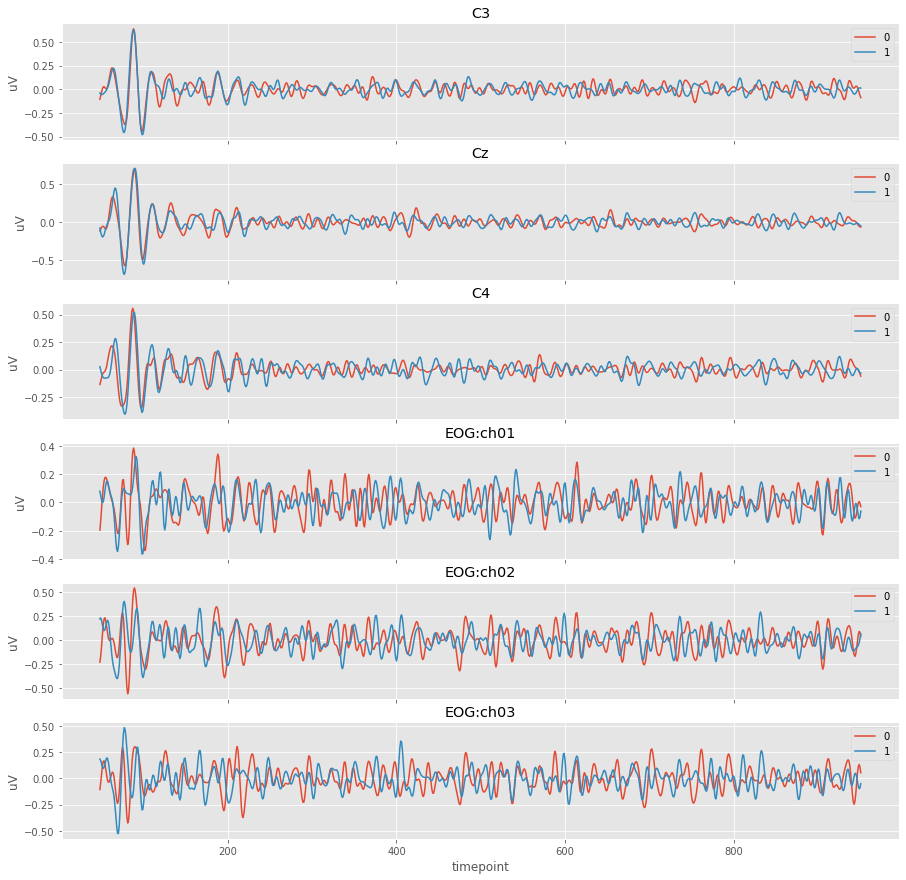

In [95]:
plot_avg_signals(left_fir_avg, right_fir_avg)

Based on Effect of EOG Signal Filtering on the Removal of Ocular Artifacts and EEG-Based Brain-Computer Interface: A Comprehensive Study, https://www.hindawi.com/journals/complexity/2018/4853741/, the motor-imagery-based BCI achieved statistically significant high-classification accuracies when artifacts from EEG were removed by using 7 Hz low-pass filtering as compared to all other filterings of EOG signals.

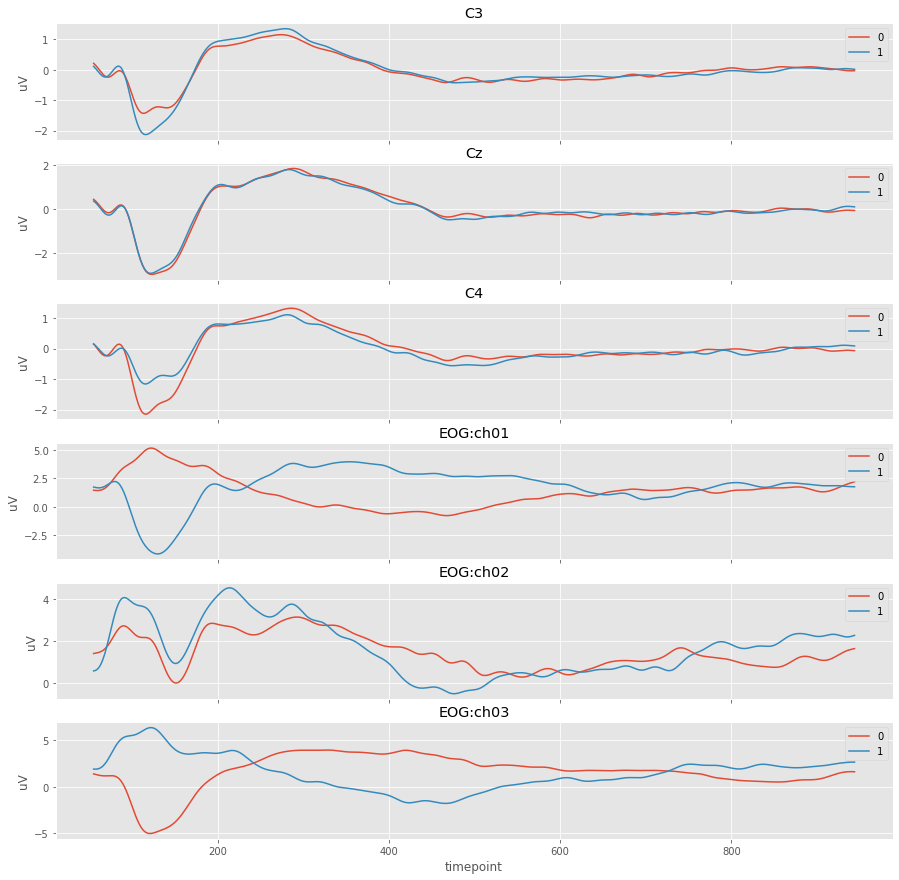

In [96]:
left_fir_avg = filter_signal_fir(left_data_avg, eeg_fs, pass_type='lowpass', f_range=(None,7))
right_fir_avg = filter_signal_fir(right_data_avg, eeg_fs, pass_type='lowpass', f_range=(None, 7))
plot_avg_signals(left_fir_avg, right_fir_avg)

### PSD 
A PSD is a frequency domain representation of a time series.
Using the Fourier transform, the signal is split into orthogonal components of different frequencies, and the amount of power in each frequency is estimated.

In [97]:
# Get Frequencies and mean PSDs from EEG data - this yeilds smoother PSDs because it averages the PSDs made from sliding windows. 
def getMeanFreqPSD(eeg_data, fs=eeg_fs):
    freq_mean, psd_mean = compute_spectrum(eeg_data, fs, method='welch', avg_type='mean', nperseg=fs*2)
    return freq_mean, np.log(psd_mean)

In [98]:
interval = range(16, 61)  # correspond to 8-30 Hz

### Lagged Coherence - average of all trials
Compute lagged coherence, reflecting the rhythmicity across a frequency range.

### Spectral coefficient of variation
Compute the spectral coefficient of variation (SCV) at each frequency.

# Feature Extraction

In [99]:
def filter_eeg(sig, f_range, pass_type, name):
    start_f, end_f = f_range
    if name == "fir":
        return filter_signal_fir(sig, eeg_fs, pass_type, f_range)
    if name == "psd":
        interval = range(2 * start_f, 2 * end_f + 1)  # correspond to frequency of f_range
        freq_mean, psd_mean = getMeanFreqPSD(sig)
        return psd_mean[interval]
    if name == "lag":
        lag, freqs = compute_lagged_coherence(sig, eeg_fs, f_range, return_spectrum=True)
        return lag
    if name == "amp":
        return amp_by_time(sig, eeg_fs, f_range)
    if name == "pha":
        return phase_by_time(sig, eeg_fs, f_range)
    if name == "i_f":
        return freq_by_time(sig, eeg_fs, f_range)
    if name == "scv":
        interval = range(start_f, end_f + 1)  # correspond to frequency of f_range
        freqs, scv = compute_scv(sig, eeg_fs)
        return scv[interval]

Filter EEG channels across all different filters and frequency ranges. This might take a few minutes.

In [100]:
filters = ["amp", "psd", "fir", "lag", "pha", "i_f", "scv"]
f_ranges = [(4, 8), (6, 10), (8, 12), (10, 14), (12, 16), (14, 18), (16, 20), (18, 22),
            (20, 24), (22, 26), (24, 28), (26, 30), (8, 30)]

In [102]:
filter_collection = {}
for _filter in filters:
    print(str(_filter) + " is being processed")
    for f_range in f_ranges:
        for chan in range(len(eeg_chans)):
            curr_key = eeg_chans[chan] + "_" + _filter + " " + str(f_range)
            if curr_key not in filter_collection:
                filter_collection[curr_key] = list()
            for i in range(len(X)):
                processed_signal = filter_eeg(X[i, chan, :], f_range, "bandpass", _filter) 
                processed_signal = processed_signal[~np.isnan(processed_signal)]  
                filter_collection[curr_key].append(processed_signal)
filtered_eeg = pd.DataFrame(filter_collection)            
filtered_eeg.head()


amp is being processed


/usr/local/lib/python3.7/dist-packages/neurodsp/filt/checks.py:173: UserWarning: Transition bandwidth is  4.0  Hz. This is greater than the desiredpass/stop bandwidth of  4.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/usr/local/lib/python3.7/dist-packages/neurodsp/filt/checks.py:173: UserWarning: Transition bandwidth is  4.5  Hz. This is greater than the desiredpass/stop bandwidth of  4.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/usr/local/lib/python3.7/dist-packages/neurodsp/filt/checks.py:173: UserWarning: Transition bandwidth is  5.0  Hz. This is greater than the desiredpass/stop bandwidth of  4.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/usr/local/lib/python3.7/dist-packages/neurodsp/filt/checks.py:173: UserWarning: Transition bandwidth is  5.8  Hz. This is greater than the desiredpass/stop bandwidth of  4.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/usr/loc

psd is being processed
fir is being processed
lag is being processed
pha is being processed
i_f is being processed
scv is being processed


,"C3_amp (4, 8)","Cz_amp (4, 8)","C4_amp (4, 8)","C3_amp (6, 10)","Cz_amp (6, 10)","C4_amp (6, 10)","C3_amp (8, 12)","Cz_amp (8, 12)","C4_amp (8, 12)","C3_amp (10, 14)","Cz_amp (10, 14)","C4_amp (10, 14)","C3_amp (12, 16)","Cz_amp (12, 16)","C4_amp (12, 16)","C3_amp (14, 18)","Cz_amp (14, 18)","C4_amp (14, 18)","C3_amp (16, 20)","Cz_amp (16, 20)","C4_amp (16, 20)","C3_amp (18, 22)","Cz_amp (18, 22)","C4_amp (18, 22)","C3_amp (20, 24)","Cz_amp (20, 24)","C4_amp (20, 24)","C3_amp (22, 26)","Cz_amp (22, 26)","C4_amp (22, 26)","C3_amp (24, 28)","Cz_amp (24, 28)","C4_amp (24, 28)","C3_amp (26, 30)","Cz_amp (26, 30)","C4_amp (26, 30)","C3_amp (8, 30)","Cz_amp (8, 30)","C4_amp (8, 30)","C3_psd (4, 8)",...,"C4_i_f (8, 30)","C3_scv (4, 8)","Cz_scv (4, 8)","C4_scv (4, 8)","C3_scv (6, 10)","Cz_scv (6, 10)","C4_scv (6, 10)","C3_scv (8, 12)","Cz_scv (8, 12)","C4_scv (8, 12)","C3_scv (10, 14)","Cz_scv (10, 14)","C4_scv (10, 14)","C3_scv (12, 16)","Cz_scv (12, 16)","C4_scv (12, 16)","C3_scv (14, 18)","Cz_scv (14, 18)","C4_scv (14, 18)","C3_scv (16, 20)","Cz_scv (16, 20)","C4_scv (16, 20)","C3_scv (18, 22)","Cz_scv (18, 22)","C4_scv (18, 22)","C3_scv (20, 24)","Cz_scv (20, 24)","C4_scv (20, 24)","C3_scv (22, 26)","Cz_scv (22, 26)","C4_scv (22, 26)","C3_scv (24, 28)","Cz_scv (24, 28)","C4_scv (24, 28)","C3_scv (26, 30)","Cz_scv (26, 30)","C4_scv (26, 30)","C3_scv (8, 30)","Cz_scv (8, 30)","C4_scv (8, 30)"
0,"[1.644548665072613, 1.6447115548820177, 1.6447...","[1.5179942096781796, 1.481922406700472, 1.4384...","[0.8837813203491532, 0.878891481172034, 0.8836...","[1.3633605447575106, 1.341232541649777, 1.3248...","[1.8405962030652796, 1.8420714355413184, 1.848...","[0.4415640795176525, 0.4683119555735013, 0.481...","[2.447369992592442, 2.4459653659627705, 2.4575...","[2.145640425433311, 2.1162803512311124, 2.0954...","[1.1054941379061967, 1.091731500604832, 1.0672...","[2.6346600114630236, 2.6603717333415027, 2.665...","[2.1960707064537477, 2.212219473718545, 2.2139...","[1.9550823474221046, 1.9009686144973847, 1.867...","[2.522951579027222, 2.5007115083638594, 2.4795...","[1.9383674008768157, 1.957418725683262, 1.9693...","[2.0144419542520606, 1.9558040482508574, 1.883...","[2.229662937842903, 2.315513558601588, 2.38361...","[1.504482812537372, 1.5784032330239757, 1.6317...","[1.9451343157822987, 1.968516054312317, 1.9364...","[1.4679649863907018, 1.690339570419544, 1.8899...","[0.840792567567322, 0.9422399117540086, 1.0545...","[1.545346987440984, 1.6344751909148503, 1.7073...","[1.1904474955037134, 1.3573253343383784, 1.524...","[0.48275009277800757, 0.5063687184288239, 0.55...","[1.2934302871999728, 1.317094787358003, 1.3651...","[1.1066750861869046, 1.1509065350847998, 1.231...","[0.5039529267477395, 0.46417265018984194, 0.41...","[1.282255361750208, 1.2694339847249276, 1.2871...","[1.0531274191736333, 0.9940912369067958, 0.965...","[0.7326492002600252, 0.7213037647950904, 0.696...","[1.2053331339726607, 1.2329541400998196, 1.256...","[1.037134952482535, 0.9112209763680222, 0.7956...","[0.8997877193476904, 0.8772665772770095, 0.855...","[1.0187753366677788, 1.0603738292807827, 1.103...","[1.1833793032464113, 0.9975045488575565, 0.806...","[1.0208413902206956, 1.0005780997216491, 1.000...","[0.6319942557027903, 0.7117714022046361, 0.807...","[1.7944654600399825, 2.630780183911483, 3.3744...","[1.9711371430903382, 2.7106043871089582, 3.317...","[1.7263500099949332, 2.1947586719363836, 2.624...","[-1.2101711009582676, -1.4676055118410156, -2....",...,"[23.56298544252439, 21.296442401737227, 20.884...","[0.5704728594630948, 0.9836339393402147, 0.973...","[0.7694499786814624, 0.6240063890842203, 0.585...","[0.5347243372729967, 0.6381782624707603, 0.583...","[0.9738886248697471, 1.2026809416958613, 0.690...","[0.585897556675572, 1.2714710448761064, 0.5364...","[0.5837060165305554, 0.42350161511641626, 0.80...","[0.6907995546547819, 0.6102344174827015, 1.027...","[0.5364547373151299, 1.3215277196256112, 1.380...","[0.8088786676239224, 1.0966864931

In [103]:
filtered_eeg.iloc[0].apply(lambda x: x.shape)

C3_amp (4, 8)      (810,)
Cz_amp (4, 8)      (810,)
C4_amp (4, 8)      (810,)
C3_amp (6, 10)     (874,)
Cz_amp (6, 10)     (874,)
                    ...  
Cz_scv (26, 30)      (5,)
C4_scv (26, 30)      (5,)
C3_scv (8, 30)      (23,)
Cz_scv (8, 30)      (23,)
C4_scv (8, 30)      (23,)
Name: 0, Length: 273, dtype: object

Save filtered features

In [104]:
filtered_eeg.to_pickle("features/filtered_eeg_all_df.pkl")

# Feature Analysis
Pipeline of extracting feature:
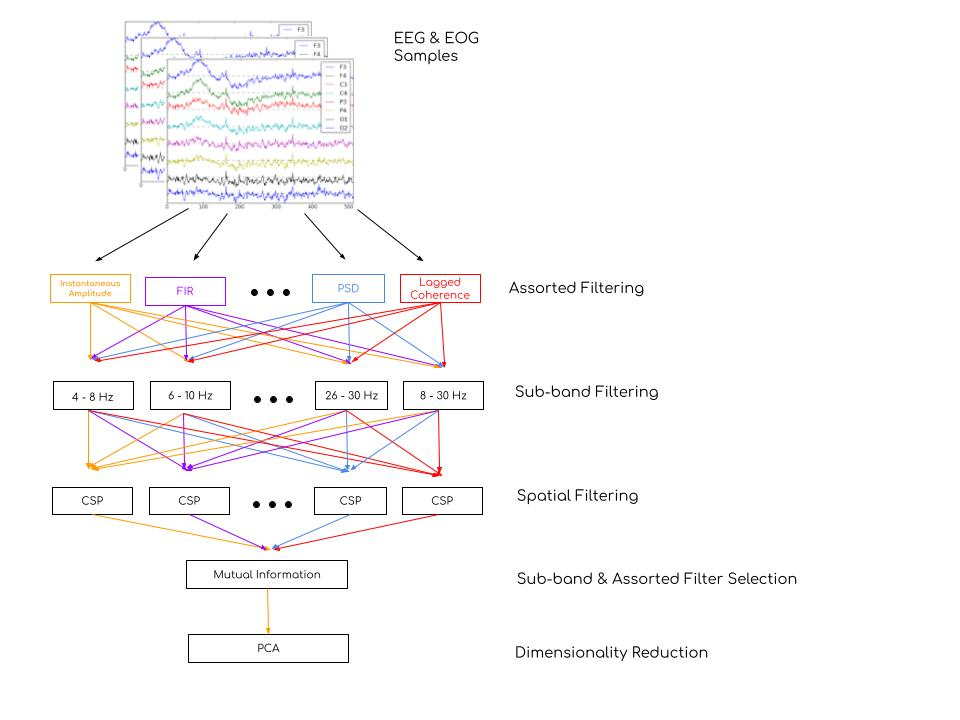 <br>
[*An improved discriminative filter bank selection approach for motor imagery EEG signal classification using mutual information* by
Shiu Kumar, Alok Sharma, and Tatsuhiko Tsunoda, 2017]

### Filters that maximize variance between the two different event types
According to https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=895946, the two best filters that maximize the difference of the variance between the two direction of signals are the most discrimitive filters, thus most helpful for building classifiers. We're going to pick 2 * m amount of filters from W, the spatial filter of CSP.

### Selecting Best Filters
According to https://www.frontiersin.org/articles/10.3389/fnins.2012.00039/full, the best filters are the ones with the highest mutual information (MI) scores. Refer to https://machinelearningmastery.com/information-gain-and-mutual-information/ for more information on MI

#### Decomposition with CSP
M/EEG signal decomposition using the Common Spatial Patterns (CSP). This object can be used as a supervised decomposition to estimate spatial filters for feature extraction. We can compare signals using mutual information once they have been decomposed with CSP. <br>
MNE CSP doc: https://mne.tools/0.11/generated/mne.decoding.CSP.html#mne.decoding.CSP <br>
MNE CSP w/ LDA doc: https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html#sphx-glr-auto-examples-decoding-plot-decoding-csp-eeg-py 

In [105]:
feature_df = pickle.load(open("features/filtered_eeg_all_df.pkl", "rb"))

In [106]:
feature_df.head()

,"C3_amp (4, 8)","Cz_amp (4, 8)","C4_amp (4, 8)","C3_amp (6, 10)","Cz_amp (6, 10)","C4_amp (6, 10)","C3_amp (8, 12)","Cz_amp (8, 12)","C4_amp (8, 12)","C3_amp (10, 14)","Cz_amp (10, 14)","C4_amp (10, 14)","C3_amp (12, 16)","Cz_amp (12, 16)","C4_amp (12, 16)","C3_amp (14, 18)","Cz_amp (14, 18)","C4_amp (14, 18)","C3_amp (16, 20)","Cz_amp (16, 20)","C4_amp (16, 20)","C3_amp (18, 22)","Cz_amp (18, 22)","C4_amp (18, 22)","C3_amp (20, 24)","Cz_amp (20, 24)","C4_amp (20, 24)","C3_amp (22, 26)","Cz_amp (22, 26)","C4_amp (22, 26)","C3_amp (24, 28)","Cz_amp (24, 28)","C4_amp (24, 28)","C3_amp (26, 30)","Cz_amp (26, 30)","C4_amp (26, 30)","C3_amp (8, 30)","Cz_amp (8, 30)","C4_amp (8, 30)","C3_psd (4, 8)",...,"C4_i_f (8, 30)","C3_scv (4, 8)","Cz_scv (4, 8)","C4_scv (4, 8)","C3_scv (6, 10)","Cz_scv (6, 10)","C4_scv (6, 10)","C3_scv (8, 12)","Cz_scv (8, 12)","C4_scv (8, 12)","C3_scv (10, 14)","Cz_scv (10, 14)","C4_scv (10, 14)","C3_scv (12, 16)","Cz_scv (12, 16)","C4_scv (12, 16)","C3_scv (14, 18)","Cz_scv (14, 18)","C4_scv (14, 18)","C3_scv (16, 20)","Cz_scv (16, 20)","C4_scv (16, 20)","C3_scv (18, 22)","Cz_scv (18, 22)","C4_scv (18, 22)","C3_scv (20, 24)","Cz_scv (20, 24)","C4_scv (20, 24)","C3_scv (22, 26)","Cz_scv (22, 26)","C4_scv (22, 26)","C3_scv (24, 28)","Cz_scv (24, 28)","C4_scv (24, 28)","C3_scv (26, 30)","Cz_scv (26, 30)","C4_scv (26, 30)","C3_scv (8, 30)","Cz_scv (8, 30)","C4_scv (8, 30)"
0,"[1.644548665072613, 1.6447115548820177, 1.6447...","[1.5179942096781796, 1.481922406700472, 1.4384...","[0.8837813203491532, 0.878891481172034, 0.8836...","[1.3633605447575106, 1.341232541649777, 1.3248...","[1.8405962030652796, 1.8420714355413184, 1.848...","[0.4415640795176525, 0.4683119555735013, 0.481...","[2.447369992592442, 2.4459653659627705, 2.4575...","[2.145640425433311, 2.1162803512311124, 2.0954...","[1.1054941379061967, 1.091731500604832, 1.0672...","[2.6346600114630236, 2.6603717333415027, 2.665...","[2.1960707064537477, 2.212219473718545, 2.2139...","[1.9550823474221046, 1.9009686144973847, 1.867...","[2.522951579027222, 2.5007115083638594, 2.4795...","[1.9383674008768157, 1.957418725683262, 1.9693...","[2.0144419542520606, 1.9558040482508574, 1.883...","[2.229662937842903, 2.315513558601588, 2.38361...","[1.504482812537372, 1.5784032330239757, 1.6317...","[1.9451343157822987, 1.968516054312317, 1.9364...","[1.4679649863907018, 1.690339570419544, 1.8899...","[0.840792567567322, 0.9422399117540086, 1.0545...","[1.545346987440984, 1.6344751909148503, 1.7073...","[1.1904474955037134, 1.3573253343383784, 1.524...","[0.48275009277800757, 0.5063687184288239, 0.55...","[1.2934302871999728, 1.317094787358003, 1.3651...","[1.1066750861869046, 1.1509065350847998, 1.231...","[0.5039529267477395, 0.46417265018984194, 0.41...","[1.282255361750208, 1.2694339847249276, 1.2871...","[1.0531274191736333, 0.9940912369067958, 0.965...","[0.7326492002600252, 0.7213037647950904, 0.696...","[1.2053331339726607, 1.2329541400998196, 1.256...","[1.037134952482535, 0.9112209763680222, 0.7956...","[0.8997877193476904, 0.8772665772770095, 0.855...","[1.0187753366677788, 1.0603738292807827, 1.103...","[1.1833793032464113, 0.9975045488575565, 0.806...","[1.0208413902206956, 1.0005780997216491, 1.000...","[0.6319942557027903, 0.7117714022046361, 0.807...","[1.7944654600399825, 2.630780183911483, 3.3744...","[1.9711371430903382, 2.7106043871089582, 3.317...","[1.7263500099949332, 2.1947586719363836, 2.624...","[-1.2101711009582676, -1.4676055118410156, -2....",...,"[23.56298544252439, 21.296442401737227, 20.884...","[0.5704728594630948, 0.9836339393402147, 0.973...","[0.7694499786814624, 0.6240063890842203, 0.585...","[0.5347243372729967, 0.6381782624707603, 0.583...","[0.9738886248697471, 1.2026809416958613, 0.690...","[0.585897556675572, 1.2714710448761064, 0.5364...","[0.5837060165305554, 0.42350161511641626, 0.80...","[0.6907995546547819, 0.6102344174827015, 1.027...","[0.5364547373151299, 1.3215277196256112, 1.380...","[0.8088786676239224, 1.0966864931

In [107]:
feature_df.iloc[0].apply(lambda x: x.shape)

C3_amp (4, 8)      (810,)
Cz_amp (4, 8)      (810,)
C4_amp (4, 8)      (810,)
C3_amp (6, 10)     (874,)
Cz_amp (6, 10)     (874,)
                    ...  
Cz_scv (26, 30)      (5,)
C4_scv (26, 30)      (5,)
C3_scv (8, 30)      (23,)
Cz_scv (8, 30)      (23,)
C4_scv (8, 30)      (23,)
Name: 0, Length: 273, dtype: object

#### Extract CSP generated across all EEG channels of each filter

In [108]:
n_components = 2 # cuz eeg comes in pairs and we don't have more than 3 channels. output number of features as well 
csp = CSP(n_components=n_components)
m = feature_df.shape[0]  # number of trials
count = 0
csp_df = np.zeros([m, len(filters) * n_components * len(f_ranges)])
columns = []
assert len(feature_df.columns) == len(filters) * len(f_ranges) * len(eeg_chans)
for i in range(0, len(feature_df.columns), len(eeg_chans)):
  print("interval:", i, i + len(eeg_chans))
  temp = np.array(feature_df[feature_df.columns.values[i: i + len(eeg_chans)]].apply(lambda x: np.concatenate(x), axis=1).values.tolist())
  n = temp.shape[1] // len(eeg_chans)
  csp_slice = np.zeros([len(eeg_chans), m, n])
  for j in range(len(eeg_chans)):
    csp_slice[j] = temp[:, n * j : n * (j + 1)]
  csp_slice = csp_slice.swapaxes(0, 1)
  print("\n\ninput shape:", csp_slice.shape)
  csp_features =   csp.fit_transform(csp_slice, y)
  print("\n\noutput shape:", csp_features.shape)
  csp_df[:, count:count + n_components] = csp_features
  count += n_components
  columns.extend(feature_df.columns.values[i: i + n_components])

csp_df = pd.DataFrame(csp_df, columns=columns)

interval: 0 3


input shape: (3680, 3, 810)
Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 3 dim * 4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 3 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.


output shape: (3680, 2)
interval: 3 6


input shape: (3680, 3, 874)
Computing rank from data with rank=None
    Using tolerance 2.9 (2.2e-16 eps * 3 dim * 4.3e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None

In [109]:
csp_df

,"C3_amp (4, 8)","Cz_amp (4, 8)","C3_amp (6, 10)","Cz_amp (6, 10)","C3_amp (8, 12)","Cz_amp (8, 12)","C3_amp (10, 14)","Cz_amp (10, 14)","C3_amp (12, 16)","Cz_amp (12, 16)","C3_amp (14, 18)","Cz_amp (14, 18)","C3_amp (16, 20)","Cz_amp (16, 20)","C3_amp (18, 22)","Cz_amp (18, 22)","C3_amp (20, 24)","Cz_amp (20, 24)","C3_amp (22, 26)","Cz_amp (22, 26)","C3_amp (24, 28)","Cz_amp (24, 28)","C3_amp (26, 30)","Cz_amp (26, 30)","C3_amp (8, 30)","Cz_amp (8, 30)","C3_psd (4, 8)","Cz_psd (4, 8)","C3_psd (6, 10)","Cz_psd (6, 10)","C3_psd (8, 12)","Cz_psd (8, 12)","C3_psd (10, 14)","Cz_psd (10, 14)","C3_psd (12, 16)","Cz_psd (12, 16)","C3_psd (14, 18)","Cz_psd (14, 18)","C3_psd (16, 20)","Cz_psd (16, 20)",...,"C3_i_f (16, 20)","Cz_i_f (16, 20)","C3_i_f (18, 22)","Cz_i_f (18, 22)","C3_i_f (20, 24)","Cz_i_f (20, 24)","C3_i_f (22, 26)","Cz_i_f (22, 26)","C3_i_f (24, 28)","Cz_i_f (24, 28)","C3_i_f (26, 30)","Cz_i_f (26, 30)","C3_i_f (8, 30)","Cz_i_f (8, 30)","C3_scv (4, 8)","Cz_scv (4, 8)","C3_scv (6, 10)","Cz_scv (6, 10)","C3_scv (8, 12)","Cz_scv (8, 12)","C3_scv (10, 14)","Cz_scv (10, 14)","C3_scv (12, 16)","Cz_scv (12, 16)","C3_scv (14, 18)","Cz_scv (14, 18)","C3_scv (16, 20)","Cz_scv (16, 20)","C3_scv (18, 22)","Cz_scv (18, 22)","C3_scv (20, 24)","Cz_scv (20, 24)","C3_scv (22, 26)","Cz_scv (22, 26)","C3_scv (24, 28)","Cz_scv (24, 28)","C3_scv (26, 30)","Cz_scv (26, 30)","C3_scv (8, 30)","Cz_scv (8, 30)"
0,-1.128911,-1.779692,-1.914677,-1.435221,-1.837756,-0.179714,-1.630225,-0.024975,-1.035281,-0.117044,-0.436726,-0.289170,-0.328074,-0.367852,-0.365847,-0.365953,-0.476655,-0.371997,-0.617970,-0.397792,-0.719761,-0.384709,-0.769000,-0.365866,-0.944085,-0.188096,-0.778988,-0.421609,-0.540061,-0.676005,-0.841301,-0.452986,-0.462461,0.054802,-1.013682,-0.536914,-1.831419,-1.098946,-1.792116,-1.574694,...,-0.590821,-1.221069,-0.837239,-0.845780,-0.411748,-0.599604,-0.798761,-0.814819,-0.869264,-0.766034,-0.427920,-0.810110,-0.735495,-0.584130,-0.611279,-0.656570,-1.342667,-0.112635,-1.052112,-1.164155,-0.843777,-1.705531,-1.957044,-0.257205,-0.707555,-0.628111,-0.293295,-0.488196,-1.386285,-1.634980,-0.331269,-1.366674,-0.319545,-1.126456,-1.753496,-2.083364,-3.187130,-1.108204,-0.783062,-0.844274
1,0.199364,-2.126241,-1.362131,-1.836360,-1.838575,-2.819142,-1.562240,-2.521596,-0.979889,-1.718492,-0.693712,-0.951795,-0.839761,-0.670350,-0.971639,-0.572359,-0.975308,-0.575465,-0.895769,-0.566328,-0.843115,-0.536403,-0.821681,-0.526448,-1.176419,-1.417617,-1.504891,0.473399,-0.287975,-1.078935,-0.528388,-1.252261,-0.245276,-1.629150,-0.820921,0.795825,-0.671215,0.741576,-1.261911,-1.086224,...,-1.259709,-0.693996,-0.607252,-0.786462,-1.033223,-0.816826,-0.842683,-1.139937,-0.355580,-0.678395,-0.600395,-0.763060,-0.309387,-0.420324,-0.949924,-0.278310,-1.019193,-1.776973,-0.428134,-1.910784,0.342300,-1.612775,-0.321070,0.212849,-0.066018,-2.616512,-0.391569,-0.635273,-0.702988,-1.849602,-1.661414,-0.888008,-0.835896,0.221960,-0.199369,0.153021,-0.145707,0.153511,-0.597730,-0.220170
2,-1.402664,-1.422067,-1.774989,-1.626607,-2.815545,-1.727904,-2.381228,-1.395981,-1.618981,-1.186902,-1.185102,-1.040393,-1.329649,-0.863823,-1.496728,-0.729279,-1.464970,-0.663158,-1.360499,-0.616667,-1.273120,-0.584606,-1.165153,-0.581951,-1.811542,-1.086800,-1.316541,-0.442260,-0.564946,-0.930917,-1.736850,-0.343605,-1.437501,-0.253159,-0.982522,-0.698613,-1.412451,-0.195505,-1.567357,-0.370443,...,-1.393627,-1.406805,-0.990766,-0.779581,-0.796050,-0.738747,-0.795984,-0.886611,-0.804140,-0.717144,-0.639785,-0.754586,-0.769015,-0.553332,0.211519,-1.371567,-1.465358,-0.805866,-1.887385,-0.957951,-1.779648,-1.866833,-0.536187,-2.020052,-0.542901,-1.627061,-0.765094,-1.688248,-1.088540,-1.502412,-0.317121,-0.605037,0.129992,-0.357286,-0.151368,-0.460390,-0.315716,-0.119739,-0.722298,-0.900886
3,-0.780193,-2.568823,-1.895166,-1.262970,-2.037316,-2.022177,-1.700319,-2.208540,-1.361263,-1.946940,-0.955179,-1.357479,-0.813632,-1.081472,-0.724615,-1.000241,-0.629264,-1.0262

Start forming features columns [f1, f2, ..., f_2m\*13], 13 is the number of bands, 2m = 3 = n_components in this case. f1 has dimension of n, n being number of trials (3680). So the df will look like (3680, num_filter), where each filter will have [f1, f2, ..., f_2m\*13]

#### Calculate and save all MI scores based on CSP

Encode labels for MI

In [110]:
labels = eeg_epoch_full_df["event_type"]
lab_enc = preprocessing.LabelEncoder()
labels_encoded = lab_enc.fit_transform(labels)  # transform labels for CSP

Calculate MI for each filter

In [111]:
m = csp_df.shape[0]  # number of trials
d = n_components * len(f_ranges)
mi_df = np.zeros([len(filters), d])
for i in range(0, len(filters)):
  temp = csp_df[csp_df.columns.values[i * d: (i + 1) * d]]
  temp = temp.values.tolist()
  temp = np.array(temp)
  mi = mutual_info_classif(temp, labels_encoded)
  mi_df[i, :] = mi
mi_df = np.swapaxes(mi_df, 0, 1)
mi = pd.DataFrame(mi_df, columns=filters)

In [112]:
mi

,amp,psd,fir,lag,pha,i_f,scv
0,0.003107,0.002637,0.005233,0.000000,0.000000,0.000895,0.008331
1,0.002851,0.000000,0.005745,0.005652,0.000000,0.003082,0.013826
2,0.011464,0.000000,0.000000,0.000000,0.000000,0.023352,0.014811
3,0.003288,0.000000,0.009218,0.006307,0.006634,0.017812,0.000000
4,0.030902,0.010403,0.015444,0.011877,0.009812,0.014604,0.007366
5,0.018140,0.011381,0.013827,0.017610,0.005876,0.003733,0.011569
6,0.027501,0.013281,0.016816,0.028090,0.003785,0.001855,0.004708
7,0.020213,0.006244,0.017922,0.014700,0.001234,0.004519,0.006148
8,0.037268,0.006279,0.016816,0.039373,0.008141,0.011031,0.018828
9,0.030151,0.006162,0.010216,0.026069,0.006310,0.026391,0.007366


In [113]:
mi.to_pickle("features/MI_scores.pkl")

Note: In practice, mi should only be applied to test data to avoid bias

#### Visualize MI scores of each feature
The maximum mutual information values for each of the sub-bands are used to form vector VMI 
(having vector length of 13 since we have 13 sub-bands in total). 
The mutual information values in VMI are arranged in descending order and the 4 bands to which the 
first 4 mutual information values in vector VMI belong to are thus selected as the top 4 bands. 

In [114]:
mi = pd.read_pickle(open("features/MI_scores.pkl", "rb"))

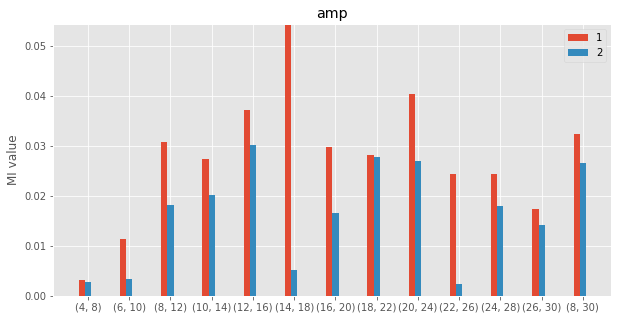

best bands: ['(14, 18)', '(20, 24)', '(12, 16)', '(8, 30)']


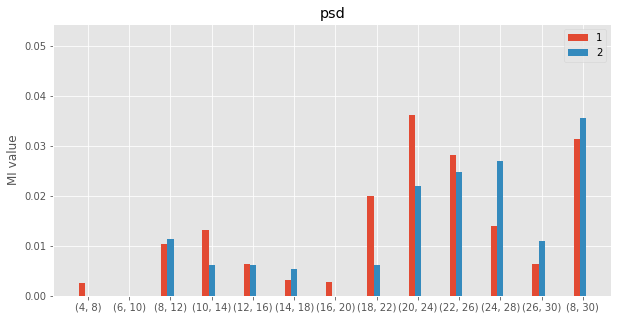

best bands: ['(20, 24)', '(8, 30)', '(22, 26)', '(24, 28)']


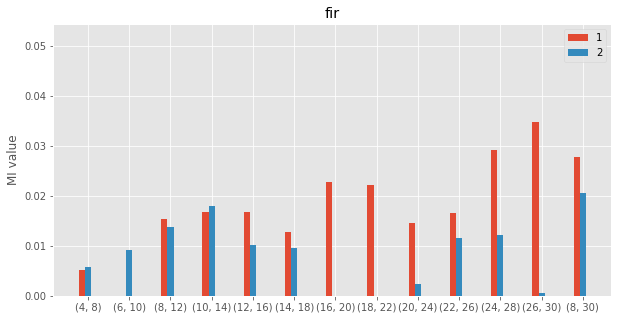

best bands: ['(26, 30)', '(24, 28)', '(8, 30)', '(16, 20)']


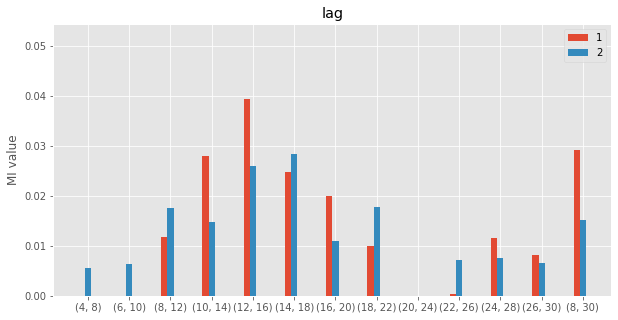

best bands: ['(12, 16)', '(8, 30)', '(14, 18)', '(10, 14)']


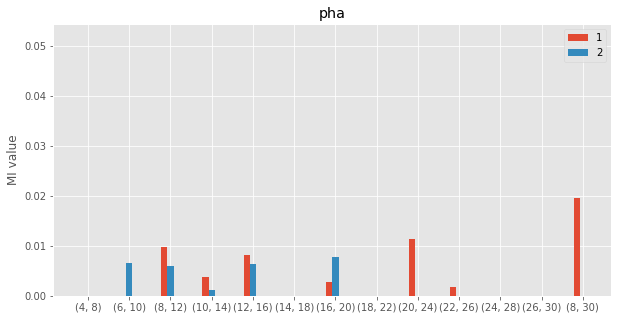

best bands: ['(8, 30)', '(20, 24)', '(8, 12)', '(12, 16)']


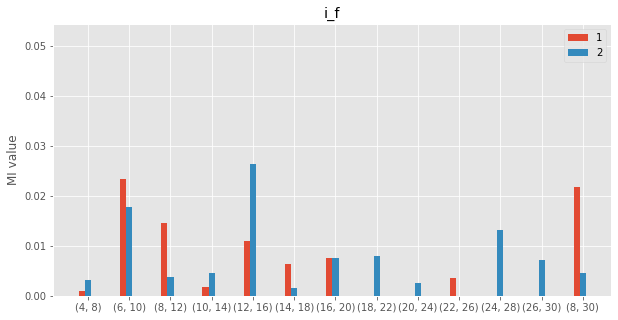

best bands: ['(12, 16)', '(6, 10)', '(8, 30)', '(8, 12)']


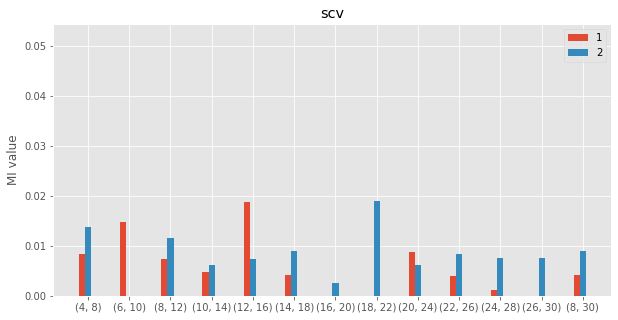

best bands: ['(18, 22)', '(12, 16)', '(6, 10)', '(4, 8)']


In [115]:
rcParams["figure.figsize"] = (10, 5)
num_feature = len(filters)
num_pairing = 4  # number of pairings

f_ranges_stack = []
for _range in f_ranges:
  f_ranges_stack.append(str(_range))
  f_ranges_stack.append(str(_range))
f_ranges_stack = np.array(f_ranges_stack)

best_bands_collection_dict = {} # top bands
best_mi_collection_dict = {} # mi values
feature_indices_dict = {} # csp features

for i in range(0, num_feature):
    best_bands_collection = []
    best_mi_collection = []
    feature_indices = []
  
    mi_slice = mi.iloc[:, i].values.tolist()
    plt.title(filters[i])
    plt.ylim(np.min(mi.values), np.max(mi.values))
    plt.ylabel("MI value")
    features = np.zeros([len(f_ranges), n_components])
    for j in range(0, d // n_components):
      features[j, :] = mi_slice[j * n_components : (j + 1) * n_components]
    features = np.swapaxes(features, 0, 1)
    plotMultipleBarGraphs(features, 0.15, bar_names=list(range(1, n_components + 1)), group_names=f_ranges)

    # find best pairing
    mi_slice = np.array(mi_slice)
    largest_indices = np.argsort(mi_slice)
    pairing_indices = largest_indices[-(num_pairing * 2):][::-1] # largest to smallest
    for index in pairing_indices:
      if len(best_bands_collection) == num_pairing:
          break
      if f_ranges_stack[index] not in best_bands_collection:
        best_bands_collection.append(f_ranges_stack[index])
        if index % 2 == 0:
          best_mi_collection.append(mi_slice[index])
          best_mi_collection.append(mi_slice[index + 1])
          feature_indices.append(index)
          feature_indices.append(index + 1)
        else:
          best_mi_collection.append(mi_slice[index - 1])
          best_mi_collection.append(mi_slice[index])
          feature_indices.append(index - 1)
          feature_indices.append(index)
    print("best bands:", best_bands_collection)
    best_bands_collection_dict[filters[i]] = best_bands_collection
    best_mi_collection_dict[filters[i]] = best_mi_collection
    feature_indices_dict[filters[i]] = feature_indices


Extract Concatenated Features 

In [116]:
concatenated_features_dict= {}
for i in range(0, num_feature):
  concatenated_features = csp_df.iloc[:, np.array(feature_indices_dict['fir']) + i * n_components * len(f_ranges)]
  print(concatenated_features)
  concatenated_features_dict[filters[i]] = concatenated_features

      C3_amp (26, 30)  Cz_amp (26, 30)  ...  C3_amp (16, 20)  Cz_amp (16, 20)
0           -0.769000        -0.365866  ...        -0.328074        -0.367852
1           -0.821681        -0.526448  ...        -0.839761        -0.670350
2           -1.165153        -0.581951  ...        -1.329649        -0.863823
3           -0.603215        -1.114245  ...        -0.813632        -1.081472
4           -0.533045        -0.844542  ...        -0.684720        -0.730600
...               ...              ...  ...              ...              ...
3675        -1.076049        -0.439246  ...        -1.855629        -0.772635
3676        -0.448466        -1.467968  ...        -0.814824        -1.947243
3677        -1.224904        -1.013247  ...        -1.336500        -1.719580
3678        -1.506263        -0.724456  ...        -1.078693        -0.897955
3679        -1.471707        -1.319719  ...        -1.698916        -1.036606

[3680 rows x 8 columns]
      C3_psd (26, 30)  Cz_psd (26, 30) 

We're going to save the features associated with the amp and fir filters, as they have the highest MI

In [117]:
csp_eeg_amp = pd.DataFrame(concatenated_features_dict["amp"])
csp_eeg_fir = pd.DataFrame(concatenated_features_dict["fir"])

In [118]:
csp_eeg_amp.head()

,"C3_amp (26, 30)","Cz_amp (26, 30)","C3_amp (24, 28)","Cz_amp (24, 28)","C3_amp (8, 30)","Cz_amp (8, 30)","C3_amp (16, 20)","Cz_amp (16, 20)"
0,-0.769000,-0.365866,-0.719761,-0.384709,-0.944085,-0.188096,-0.328074,-0.367852
1,-0.821681,-0.526448,-0.843115,-0.536403,-1.176419,-1.417617,-0.839761,-0.670350
2,-1.165153,-0.581951,-1.273120,-0.584606,-1.811542,-1.086800,-1.329649,-0.863823
3,-0.603215,-1.114245,-0.580770,-1.155830,-1.151900,-1.527767,-0.813632,-1.081472
4,-0.533045,-0.844542,-0.527432,-0.768915,-1.291977,-1.544434,-0.684720,-0.730600


In [119]:
csp_eeg_amp.to_pickle("features/csp_eeg_amp.pkl")
csp_eeg_fir.to_pickle("features/csp_eeg_fir.pkl")

### Filter EOG channels
Based on Effect of EOG Signal Filtering on the Removal of Ocular Artifacts and EEG-Based Brain-Computer Interface: A Comprehensive Study, https://www.hindawi.com/journals/complexity/2018/4853741/, the motor-imagery-based BCI achieved statistically significant high-classification accuracies when artifacts from EEG were removed by using 7 Hz low-pass filtering as compared to all other filterings of EOG signals.

In [120]:
filters = ["fir"]
f_ranges = [(None, 7)]

In [121]:
filter_collection = {}
for _filter in filters:
    print(str(_filter) + " is being processed")
    for f_range in f_ranges:
        for chan in range(len(eeg_chans)):
            curr_key = eog_chans[chan] + "_" + _filter + " " + str(f_range)
            if curr_key not in filter_collection:
                filter_collection[curr_key] = list()
            for i in range(len(X)):
                processed_signal = filter_eeg(X[i, chan, :], f_range, "lowpass", _filter) 
                processed_signal = processed_signal[~np.isnan(processed_signal)]  
                filter_collection[curr_key].append(processed_signal)
filtered_eog = pd.DataFrame(filter_collection)            
filtered_eog.head()

fir is being processed


,"EOG:ch01_fir (None, 7)","EOG:ch02_fir (None, 7)","EOG:ch03_fir (None, 7)"
0,"[-1.9689760191125543, -2.1060343645975035, -2....","[-2.802581388938609, -2.99494305726164, -3.165...","[-2.1626909493504503, -2.198155953906421, -2.2..."
1,"[0.7579239924814452, 0.6347813021438288, 0.521...","[3.783609737367813, 3.492824673661024, 3.19811...","[-1.145244524328565, -1.3333210151409487, -1.5..."
2,"[1.492522884001345, 1.6021129321588994, 1.6905...","[0.41578651605135575, 0.37431204734818035, 0.3...","[0.026980197034669903, 0.09982509969966308, 0...."
3,"[-0.6699346548900674, -0.6035151207591053, -0....","[-0.523277073304208, -0.6400217232209018, -0.7...","[-0.936500282365868, -0.9652713865374931, -0.9..."
4,"[-2.0265698497525446, -2.140674606627864, -2.2...","[-1.2206947811017546, -1.4237685607920216, -1....","[-1.7132530835867492, -1.7770380179468015, -1...."


In [122]:
filtered_eog.iloc[0].apply(lambda x: x.shape)

EOG:ch01_fir (None, 7)    (890,)
EOG:ch02_fir (None, 7)    (890,)
EOG:ch03_fir (None, 7)    (890,)
Name: 0, dtype: object

PCA on EOG features


In [123]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from numpy import mean, std

In [124]:
X_eog = X[:, len(eeg_chans):, :]

In [125]:
# get a list of models to evaluate
def get_models(start=1, end=890, step_size=200):
	models = dict()
	for i in range(start, end, step_size):
		steps = [('pca', PCA(n_components=i)), ('svc', SVC(C=3))]
		models[str(i)] = Pipeline(steps=steps)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

Step size of PCA = 200, (1, 890)

>EOG:ch01 1 0.633 (0.017)
>EOG:ch01 201 0.715 (0.019)
>EOG:ch01 401 0.715 (0.018)
>EOG:ch01 601 0.712 (0.016)
>EOG:ch01 801 0.710 (0.017)


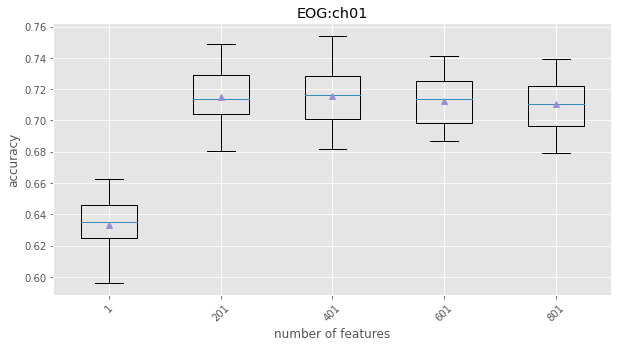

>EOG:ch02 1 0.497 (0.019)
>EOG:ch02 201 0.523 (0.020)
>EOG:ch02 401 0.513 (0.018)
>EOG:ch02 601 0.517 (0.017)
>EOG:ch02 801 0.515 (0.017)


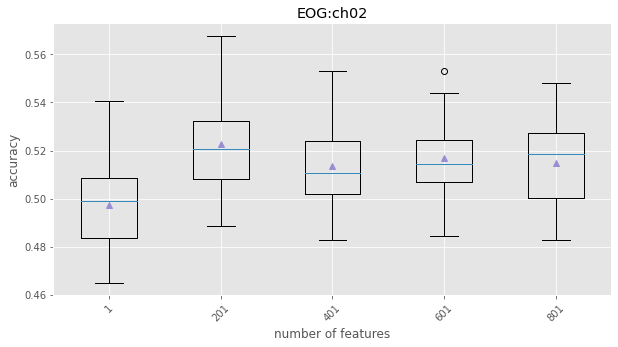

>EOG:ch03 1 0.540 (0.025)
>EOG:ch03 201 0.674 (0.014)
>EOG:ch03 401 0.668 (0.018)
>EOG:ch03 601 0.663 (0.022)
>EOG:ch03 801 0.659 (0.018)


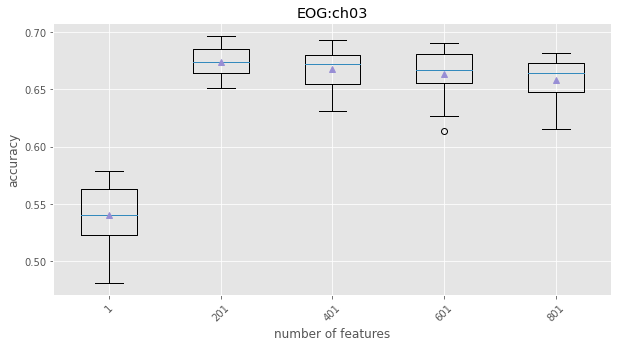

In [126]:
for chan in range(len(eog_chans)):
  # get the models to evaluate
  models = get_models()
  # evaluate the models and store results
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, X_eog[:, chan, :], y)
    results.append(scores)
    names.append(name)
    print('>%s %s %.3f (%.3f)' % (eog_chans[chan], name, mean(scores), std(scores)))
  # plot model performance for comparison
  plt.title(eog_chans[chan])
  plt.xlabel("number of features")
  plt.ylabel("accuracy")
  plt.boxplot(results, labels=names, showmeans=True)
  plt.xticks(rotation=45)
  plt.show()

Step size of PCA = 20, (1, 201)

>EOG:ch01 1 0.633 (0.017)
>EOG:ch01 21 0.712 (0.022)
>EOG:ch01 41 0.717 (0.023)
>EOG:ch01 61 0.712 (0.022)
>EOG:ch01 81 0.716 (0.022)
>EOG:ch01 101 0.715 (0.020)
>EOG:ch01 121 0.716 (0.019)
>EOG:ch01 141 0.713 (0.020)
>EOG:ch01 161 0.713 (0.019)
>EOG:ch01 181 0.714 (0.018)


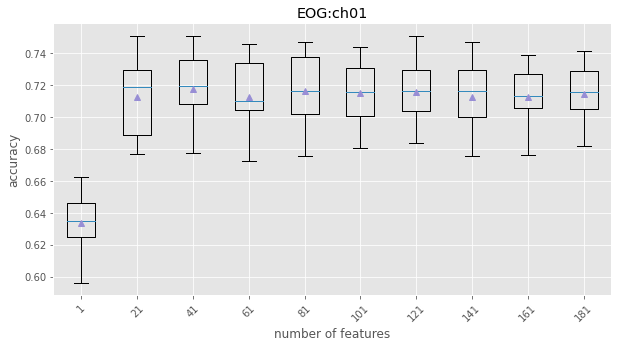

>EOG:ch02 1 0.497 (0.019)
>EOG:ch02 21 0.529 (0.015)
>EOG:ch02 41 0.526 (0.016)
>EOG:ch02 61 0.526 (0.020)
>EOG:ch02 81 0.529 (0.020)
>EOG:ch02 101 0.527 (0.027)
>EOG:ch02 121 0.526 (0.024)
>EOG:ch02 141 0.528 (0.027)
>EOG:ch02 161 0.524 (0.023)
>EOG:ch02 181 0.523 (0.023)


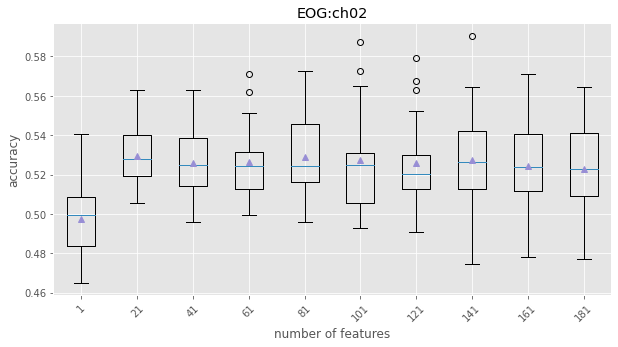

>EOG:ch03 1 0.540 (0.025)
>EOG:ch03 21 0.682 (0.016)
>EOG:ch03 41 0.683 (0.017)
>EOG:ch03 61 0.679 (0.020)
>EOG:ch03 81 0.683 (0.018)
>EOG:ch03 101 0.679 (0.019)
>EOG:ch03 121 0.677 (0.018)
>EOG:ch03 141 0.677 (0.017)
>EOG:ch03 161 0.673 (0.018)
>EOG:ch03 181 0.673 (0.015)


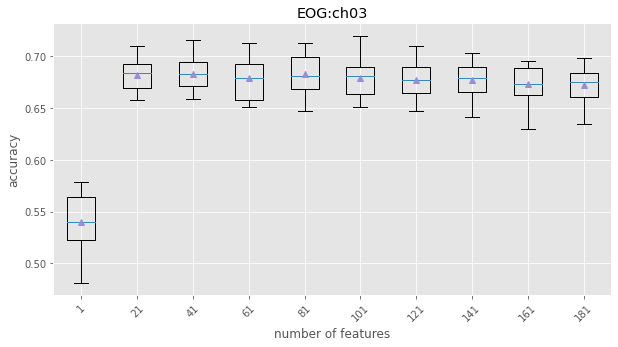

In [127]:
for chan in range(len(eog_chans)):
  # get the models to evaluate
  models = get_models(start=1, end=201, step_size=20)
  # evaluate the models and store results
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, X_eog[:, chan, :], y)
    results.append(scores)
    names.append(name)
    print('>%s %s %.3f (%.3f)' % (eog_chans[chan], name, mean(scores), std(scores)))
  # plot model performance for comparison
  plt.title(eog_chans[chan])
  plt.xlabel("number of features")
  plt.ylabel("accuracy")
  plt.boxplot(results, labels=names, showmeans=True)
  plt.xticks(rotation=45)
  plt.show()

Step size of PCA = 2, (1, 21)

>EOG:ch01 1 0.633 (0.017)
>EOG:ch01 3 0.688 (0.028)
>EOG:ch01 5 0.704 (0.019)
>EOG:ch01 7 0.703 (0.021)
>EOG:ch01 9 0.709 (0.022)
>EOG:ch01 11 0.713 (0.019)
>EOG:ch01 13 0.706 (0.024)
>EOG:ch01 15 0.710 (0.020)
>EOG:ch01 17 0.711 (0.021)
>EOG:ch01 19 0.710 (0.022)


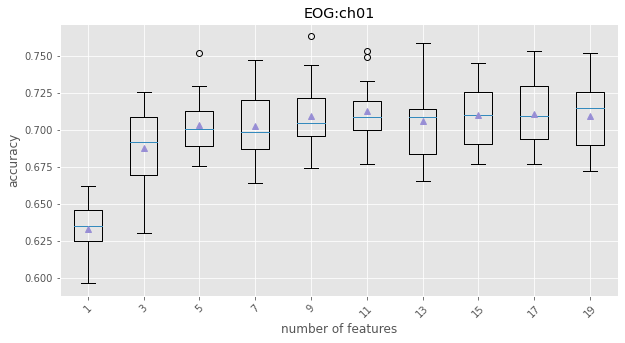

>EOG:ch02 1 0.497 (0.019)
>EOG:ch02 3 0.520 (0.018)
>EOG:ch02 5 0.529 (0.017)
>EOG:ch02 7 0.532 (0.016)
>EOG:ch02 9 0.531 (0.017)
>EOG:ch02 11 0.534 (0.019)
>EOG:ch02 13 0.534 (0.020)
>EOG:ch02 15 0.532 (0.021)
>EOG:ch02 17 0.532 (0.021)
>EOG:ch02 19 0.530 (0.018)


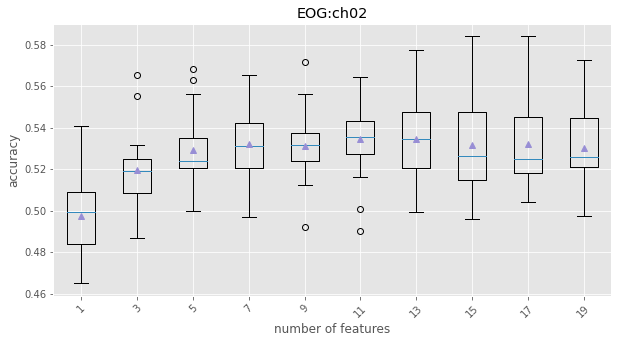

>EOG:ch03 1 0.540 (0.025)
>EOG:ch03 3 0.654 (0.012)
>EOG:ch03 5 0.659 (0.016)
>EOG:ch03 7 0.677 (0.012)
>EOG:ch03 9 0.680 (0.016)
>EOG:ch03 11 0.682 (0.016)
>EOG:ch03 13 0.682 (0.017)
>EOG:ch03 15 0.687 (0.019)
>EOG:ch03 17 0.687 (0.017)
>EOG:ch03 19 0.685 (0.016)


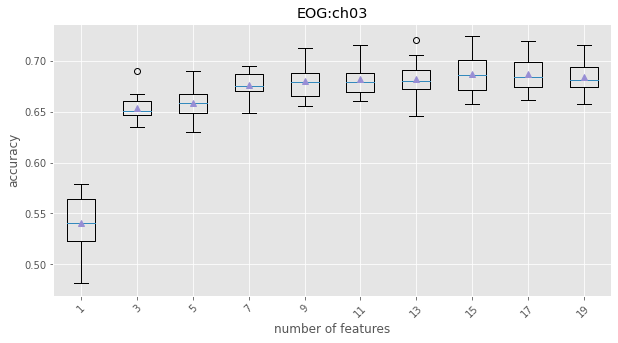

In [128]:
for chan in range(len(eog_chans)):
  # get the models to evaluate
  models = get_models(start=1, end=21, step_size=2)
  # evaluate the models and store results
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, X_eog[:, chan, :], y)
    results.append(scores)
    names.append(name)
    print('>%s %s %.3f (%.3f)' % (eog_chans[chan], name, mean(scores), std(scores)))
  # plot model performance for comparison
  plt.title(eog_chans[chan])
  plt.xlabel("number of features")
  plt.ylabel("accuracy")
  plt.boxplot(results, labels=names, showmeans=True)
  plt.xticks(rotation=45)
  plt.show()

In [129]:
filtered_eog_all = []
for chan in range(len(eog_chans)):
  pca = PCA(n_components=11)
  pca.fit(X_eog[:, chan, :])
  transformed = pca.transform(X_eog[:, chan, :])
  transformed = pd.DataFrame(transformed)
  filtered_eog_all.append(transformed)
  transformed.to_pickle("features/filtered_" + eog_chans[chan] + ".pkl")

In [130]:
filtered_eog_all = np.concatenate(filtered_eog_all, axis=-1)

In [131]:
filtered_eog_all = pd.DataFrame(filtered_eog_all)
filtered_eog_all.to_pickle("features/filtered_eog_all.pkl")

### PCA on top 4 bands of EEG channels 

In [132]:
feature_df = pickle.load(open("features/filtered_eeg_all_df.pkl", "rb"))

In [133]:
feature_df.head()

,"C3_amp (4, 8)","Cz_amp (4, 8)","C4_amp (4, 8)","C3_amp (6, 10)","Cz_amp (6, 10)","C4_amp (6, 10)","C3_amp (8, 12)","Cz_amp (8, 12)","C4_amp (8, 12)","C3_amp (10, 14)","Cz_amp (10, 14)","C4_amp (10, 14)","C3_amp (12, 16)","Cz_amp (12, 16)","C4_amp (12, 16)","C3_amp (14, 18)","Cz_amp (14, 18)","C4_amp (14, 18)","C3_amp (16, 20)","Cz_amp (16, 20)","C4_amp (16, 20)","C3_amp (18, 22)","Cz_amp (18, 22)","C4_amp (18, 22)","C3_amp (20, 24)","Cz_amp (20, 24)","C4_amp (20, 24)","C3_amp (22, 26)","Cz_amp (22, 26)","C4_amp (22, 26)","C3_amp (24, 28)","Cz_amp (24, 28)","C4_amp (24, 28)","C3_amp (26, 30)","Cz_amp (26, 30)","C4_amp (26, 30)","C3_amp (8, 30)","Cz_amp (8, 30)","C4_amp (8, 30)","C3_psd (4, 8)",...,"C4_i_f (8, 30)","C3_scv (4, 8)","Cz_scv (4, 8)","C4_scv (4, 8)","C3_scv (6, 10)","Cz_scv (6, 10)","C4_scv (6, 10)","C3_scv (8, 12)","Cz_scv (8, 12)","C4_scv (8, 12)","C3_scv (10, 14)","Cz_scv (10, 14)","C4_scv (10, 14)","C3_scv (12, 16)","Cz_scv (12, 16)","C4_scv (12, 16)","C3_scv (14, 18)","Cz_scv (14, 18)","C4_scv (14, 18)","C3_scv (16, 20)","Cz_scv (16, 20)","C4_scv (16, 20)","C3_scv (18, 22)","Cz_scv (18, 22)","C4_scv (18, 22)","C3_scv (20, 24)","Cz_scv (20, 24)","C4_scv (20, 24)","C3_scv (22, 26)","Cz_scv (22, 26)","C4_scv (22, 26)","C3_scv (24, 28)","Cz_scv (24, 28)","C4_scv (24, 28)","C3_scv (26, 30)","Cz_scv (26, 30)","C4_scv (26, 30)","C3_scv (8, 30)","Cz_scv (8, 30)","C4_scv (8, 30)"
0,"[1.644548665072613, 1.6447115548820177, 1.6447...","[1.5179942096781796, 1.481922406700472, 1.4384...","[0.8837813203491532, 0.878891481172034, 0.8836...","[1.3633605447575106, 1.341232541649777, 1.3248...","[1.8405962030652796, 1.8420714355413184, 1.848...","[0.4415640795176525, 0.4683119555735013, 0.481...","[2.447369992592442, 2.4459653659627705, 2.4575...","[2.145640425433311, 2.1162803512311124, 2.0954...","[1.1054941379061967, 1.091731500604832, 1.0672...","[2.6346600114630236, 2.6603717333415027, 2.665...","[2.1960707064537477, 2.212219473718545, 2.2139...","[1.9550823474221046, 1.9009686144973847, 1.867...","[2.522951579027222, 2.5007115083638594, 2.4795...","[1.9383674008768157, 1.957418725683262, 1.9693...","[2.0144419542520606, 1.9558040482508574, 1.883...","[2.229662937842903, 2.315513558601588, 2.38361...","[1.504482812537372, 1.5784032330239757, 1.6317...","[1.9451343157822987, 1.968516054312317, 1.9364...","[1.4679649863907018, 1.690339570419544, 1.8899...","[0.840792567567322, 0.9422399117540086, 1.0545...","[1.545346987440984, 1.6344751909148503, 1.7073...","[1.1904474955037134, 1.3573253343383784, 1.524...","[0.48275009277800757, 0.5063687184288239, 0.55...","[1.2934302871999728, 1.317094787358003, 1.3651...","[1.1066750861869046, 1.1509065350847998, 1.231...","[0.5039529267477395, 0.46417265018984194, 0.41...","[1.282255361750208, 1.2694339847249276, 1.2871...","[1.0531274191736333, 0.9940912369067958, 0.965...","[0.7326492002600252, 0.7213037647950904, 0.696...","[1.2053331339726607, 1.2329541400998196, 1.256...","[1.037134952482535, 0.9112209763680222, 0.7956...","[0.8997877193476904, 0.8772665772770095, 0.855...","[1.0187753366677788, 1.0603738292807827, 1.103...","[1.1833793032464113, 0.9975045488575565, 0.806...","[1.0208413902206956, 1.0005780997216491, 1.000...","[0.6319942557027903, 0.7117714022046361, 0.807...","[1.7944654600399825, 2.630780183911483, 3.3744...","[1.9711371430903382, 2.7106043871089582, 3.317...","[1.7263500099949332, 2.1947586719363836, 2.624...","[-1.2101711009582676, -1.4676055118410156, -2....",...,"[23.56298544252439, 21.296442401737227, 20.884...","[0.5704728594630948, 0.9836339393402147, 0.973...","[0.7694499786814624, 0.6240063890842203, 0.585...","[0.5347243372729967, 0.6381782624707603, 0.583...","[0.9738886248697471, 1.2026809416958613, 0.690...","[0.585897556675572, 1.2714710448761064, 0.5364...","[0.5837060165305554, 0.42350161511641626, 0.80...","[0.6907995546547819, 0.6102344174827015, 1.027...","[0.5364547373151299, 1.3215277196256112, 1.380...","[0.8088786676239224, 1.0966864931

Create a feature column names

In [134]:
best_bands_amp = ['(14, 18)', '(20, 24)', '(12, 16)', '(8, 30)']
feature_col_names = []
for chan in eeg_chans:
  for band in best_bands_amp:
    feature_col_names.append(chan + "_amp " + band)

In [136]:
X_eeg = feature_df[feature_col_names]

In [138]:
X_eeg = np.array(X_eeg.apply(lambda x: np.concatenate(x, axis=0), axis=1).values.tolist())

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


>1 0.490 (0.020)
>11 0.677 (0.018)
>21 0.692 (0.017)
>31 0.694 (0.014)
>41 0.692 (0.016)
>51 0.689 (0.016)
>61 0.690 (0.014)
>71 0.690 (0.015)
>81 0.694 (0.016)
>91 0.690 (0.017)


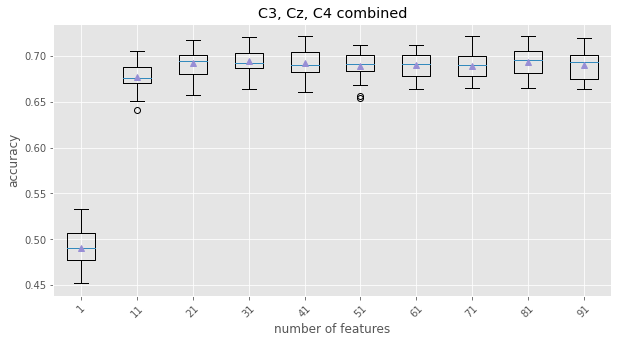

In [140]:
# get the models to evaluate
models = get_models(start=1, end=100, step_size=10)
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X_eeg, y)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.title("C3, Cz, C4 combined")
plt.xlabel("number of features")
plt.ylabel("accuracy")
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

In [141]:
  pca = PCA(n_components=31)
  pca.fit(X_eeg)
  transformed = pca.transform(X_eeg)
  transformed = pd.DataFrame(transformed)

In [142]:
transformed.shape

(3680, 31)

In [143]:
transformed.to_pickle("features/pca_eeg_amp.pkl")

# Modeling




Load filtered features. We'll see train the model using three eeg channels and one eog channels

In [144]:
eeg_features = pd.read_pickle("features/csp_eeg_amp.pkl")
eeg_features = tf.keras.utils.normalize(eeg_features)
eog_fir = pd.read_pickle("features/filtered_eog_all.pkl")
eog_fir = tf.keras.utils.normalize(eog_fir)

In [145]:
print(eeg_features.describe())
eeg_features.head()

       C3_amp (26, 30)  Cz_amp (26, 30)  ...  C3_amp (16, 20)  Cz_amp (16, 20)
count      3680.000000      3680.000000  ...      3680.000000      3680.000000
mean         -0.283357        -0.289793  ...        -0.271968        -0.281642
std           0.208204         0.156752  ...         0.204787         0.188575
min          -0.700494        -0.728197  ...        -0.758093        -0.864233
25%          -0.421355        -0.382960  ...        -0.395608        -0.402548
50%          -0.331095        -0.317444  ...        -0.325214        -0.316294
75%          -0.200719        -0.231372  ...        -0.222442        -0.195139
max           0.770168         0.691426  ...         0.787330         0.792032

[8 rows x 8 columns]


,"C3_amp (26, 30)","Cz_amp (26, 30)","C3_amp (24, 28)","Cz_amp (24, 28)","C3_amp (8, 30)","Cz_amp (8, 30)","C3_amp (16, 20)","Cz_amp (16, 20)"
0,-0.480541,-0.228626,-0.449771,-0.240401,-0.589949,-0.117539,-0.205010,-0.229867
1,-0.322314,-0.206505,-0.330721,-0.210410,-0.461463,-0.556076,-0.329405,-0.262952
2,-0.357271,-0.178444,-0.390376,-0.179258,-0.555473,-0.333245,-0.407710,-0.264874
3,-0.203678,-0.376229,-0.196099,-0.390270,-0.388943,-0.515856,-0.274726,-0.365163
4,-0.202576,-0.320956,-0.200443,-0.292215,-0.490997,-0.586940,-0.260218,-0.277654


In [146]:
print(eog_fir.describe())
eog_fir.head()

                0            1   ...           31           32
count  3680.000000  3680.000000  ...  3680.000000  3680.000000
mean     -0.018871     0.007854  ...     0.011059    -0.001002
std       0.316179     0.233204  ...     0.138409     0.136923
min      -0.840393    -0.814002  ...    -0.772283    -0.823621
25%      -0.195205    -0.112578  ...    -0.051292    -0.061872
50%      -0.025717     0.013847  ...     0.015871    -0.000716
75%       0.143300     0.139588  ...     0.086187     0.060193
max       0.843403     0.804433  ...     0.637234     0.764435

[8 rows x 33 columns]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,-0.167257,0.054010,-0.100958,0.030275,0.168117,-0.152254,-0.028266,-0.137973,0.162344,0.024992,-0.135958,-0.262311,-0.403898,0.093202,-0.067060,-0.395585,-0.199807,0.182709,0.343872,-0.101651,0.135726,0.079904,0.039071,-0.280683,-0.245233,0.095611,-0.186523,0.085627,-0.095985,0.036215,-0.027827,-0.079668,0.059926
1,-0.066852,-0.050169,0.118317,-0.094500,-0.025322,0.065130,0.090031,-0.113421,0.094724,0.024945,-0.098091,-0.353523,-0.395537,-0.040431,0.196001,-0.395582,-0.345429,0.136800,-0.030488,-0.383019,-0.014133,-0.097657,0.020291,0.216195,-0.068739,0.253586,-0.120313,-0.031456,0.008479,0.123685,0.018165,0.033320,0.056460
2,0.150313,-0.102070,-0.038202,0.073252,0.027690,-0.143336,-0.204996,0.048719,-0.069347,0.079219,-0.016090,0.066002,0.326904,-0.281229,0.063033,0.358119,0.004605,0.139112,-0.231810,-0.259258,0.002617,0.413374,-0.027970,-0.395584,0.035937,0.217539,0.038218,0.067041,0.054281,0.074249,0.036086,0.106979,0.127755
3,-0.197650,-0.004006,-0.062191,-0.095649,-0.050658,0.081927,0.019873,-0.020990,0.017973,0.018162,-0.005951,-0.098709,-0.446068,0.402128,-0.052853,-0.220059,0.072480,0.041671,-0.574121,-0.159932,0.076322,-0.040285,-0.007996,-0.070618,-0.120984,0.120065,-0.080783,-0.249442,-0.165678,0.117661,0.035058,-0.018669,0.010039
4,-0.071444,0.118935,0.217588,0.076682,-0.110700,-0.143785,0.125741,-0.019467,0.157297,0.063367,-0.063238,0.231251,-0.341626,-0.184811,0.277406,-0.052063,0.104529,0.025673,0.091713,-0.424500,0.052322,0.361097,0.066236,-0.076674,-0.056893,-0.111347,0.194078,0.114272,0.188894,0.308835,-0.079673,-0.000988,0.119520


In [147]:
# concatenated_features = np.concatenate([eeg_features, eog_fir], axis=1)
concatenated_features = eeg_features

Compare models based on accuracy

In [148]:
# get a stacking ensemble of models
def get_stacking(verbosity=0):
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('svm', SVC(C=3)))
    level0.append(('ada', AdaBoostClassifier()))
    level0.append(('rfor', RandomForestClassifier()))
    level0.append(('gnb', GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=6, verbose=verbosity)
    return model

In [149]:
print("SVM:",cross_val_score(SVC(C=3), concatenated_features, y, cv=6).mean())
print("Gaussian:",cross_val_score(GaussianNB(), concatenated_features, y, cv=6).mean())
print("Logistic Regression:",cross_val_score(LogisticRegression(), concatenated_features, y, cv=6).mean())
print("Adaboost:",cross_val_score(AdaBoostClassifier(), concatenated_features, y, cv=6).mean())
print("Random Forest:",cross_val_score(RandomForestClassifier(), concatenated_features, y, cv=6).mean())
print("Stacking:",cross_val_score(get_stacking(), concatenated_features, y, cv=6).mean())

SVM: 0.6921553988589606
Gaussian: 0.6399787981359364
Logistic Regression: 0.6826433428449464
Adaboost: 0.6668849732452667
Random Forest: 0.6845523076732327
Stacking: 0.6951439406418656


#### DNN using Keras Sequential

In [150]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [151]:
# Build model using keras's Sequential API
def create_nn(dropout_rate=0.4, learn_rate=0.0007):
    neural_network = Sequential()
    neural_network.add(Dense(2048, activation="relu"))
    neural_network.add(Dropout(dropout_rate))
    neural_network.add(Dense(1024, activation="relu"))
    neural_network.add(Dropout(dropout_rate))
    neural_network.add(Dense(512, activation="relu"))
    neural_network.add(Dropout(dropout_rate))
    neural_network.add(Dense(128, activation="relu"))
    neural_network.add(Dropout(dropout_rate))
    neural_network.add(Dense(1, activation="sigmoid"))
    # reproducible results
    np.random.seed(37)
    tf.random.set_seed(89)
    opt = Adam(lr=learn_rate)
    neural_network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return neural_network

In [152]:
# evaluate test set performance at the end of each epoch
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_acc_history.append(self.model.evaluate(x_test, y_test, verbose=0)[1])
        if (epoch + 1) % 5 == 0:
            print(f"{epoch + 1} epoch with test_acc: {test_acc_history[epoch]}")

In [153]:
x_train, x_test, y_train, y_test = train_test_split(concatenated_features, y, test_size=1/6, random_state=10)
model = create_nn(0.6, learn_rate=0.0001)
epochs = 50
test_acc_history = list()  # reset test accuracy history
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, callbacks=[CustomCallback()], verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


5 epoch with test_acc: 0.6726384162902832
10 epoch with test_acc: 0.6807817816734314
15 epoch with test_acc: 0.6856677532196045
20 epoch with test_acc: 0.6644951105117798
25 epoch with test_acc: 0.6661238074302673
30 epoch with test_acc: 0.6921824216842651
35 epoch with test_acc: 0.7003257274627686
40 epoch with test_acc: 0.7068403959274292
45 epoch with test_acc: 0.7100977301597595
50 epoch with test_acc: 0.7052116990089417


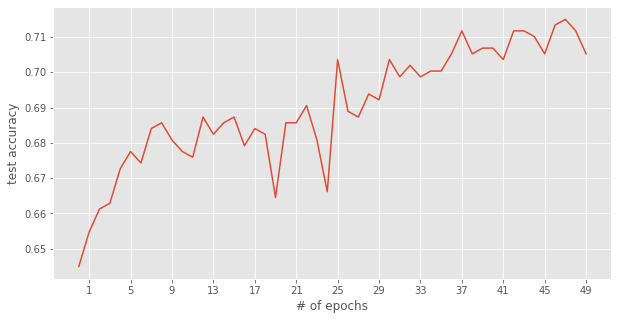

In [154]:
plt.xlabel("# of epochs")
plt.ylabel("test accuracy")
plt.xticks(np.arange(1, epochs + 1, int(((epochs + 1) / 11))))
plt.plot(test_acc_history)
plt.show()

In [155]:
from sklearn.model_selection import StratifiedKFold
X = np.array(concatenated_features.values.tolist())
Y = y

In [156]:
seed = 7
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  # create model
  model = create_nn(0.6, learn_rate=0.0001)
  epochs = 50
  history = model.fit(X[train], Y[train], epochs=epochs, batch_size=64, callbacks=[CustomCallback()], verbose=0)
  # evaluate the model
  scores = model.evaluate(X[test], Y[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


5 epoch with test_acc: 0.6726384162902832
10 epoch with test_acc: 0.6807817816734314
15 epoch with test_acc: 0.6856677532196045
20 epoch with test_acc: 0.6644951105117798
25 epoch with test_acc: 0.6661238074302673
30 epoch with test_acc: 0.6921824216842651
35 epoch with test_acc: 0.7003257274627686
40 epoch with test_acc: 0.7068403959274292
45 epoch with test_acc: 0.7100977301597595
50 epoch with test_acc: 0.7052116990089417
accuracy: 69.38%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


5 epoch with test_acc: 0.6726384162902832
10 epoch with test_acc: 0.6807817816734314
15 epoch with test_acc: 0.6856677532196045
20 epoch with test_acc: 0.6644951105117798
25 epoch with test_acc: 0.6661238074302673
30 epoch with test_acc: 0.6921824216842651
35 epoch with test_acc: 0.7003257274627686
40 epoch with test_acc: 0.7068403959274292
45 epoch with test_acc: 0.7100977301597595
50 epoch with test_acc: 0.7052116990089417
accuracy: 70.20%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


5 epoch with test_acc: 0.6726384162902832
10 epoch with test_acc: 0.6807817816734314
15 epoch with test_acc: 0.6856677532196045
20 epoch with test_acc: 0.6644951105117798
25 epoch with test_acc: 0.6661238074302673
30 epoch with test_acc: 0.6921824216842651
35 epoch with test_acc: 0.7003257274627686
40 epoch with test_acc: 0.7068403959274292
45 epoch with test_acc: 0.7100977301597595
50 epoch with test_acc: 0.7052116990089417
accuracy: 70.80%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


5 epoch with test_acc: 0.6726384162902832
10 epoch with test_acc: 0.6807817816734314
15 epoch with test_acc: 0.6856677532196045
20 epoch with test_acc: 0.6644951105117798
25 epoch with test_acc: 0.6661238074302673
30 epoch with test_acc: 0.6921824216842651
35 epoch with test_acc: 0.7003257274627686
40 epoch with test_acc: 0.7068403959274292
45 epoch with test_acc: 0.7100977301597595
50 epoch with test_acc: 0.7052116990089417
accuracy: 72.76%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


5 epoch with test_acc: 0.6726384162902832
10 epoch with test_acc: 0.6807817816734314
15 epoch with test_acc: 0.6856677532196045
20 epoch with test_acc: 0.6644951105117798
25 epoch with test_acc: 0.6661238074302673
30 epoch with test_acc: 0.6921824216842651
35 epoch with test_acc: 0.7003257274627686
40 epoch with test_acc: 0.7068403959274292
45 epoch with test_acc: 0.7100977301597595
50 epoch with test_acc: 0.7052116990089417
accuracy: 70.80%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


5 epoch with test_acc: 0.6726384162902832
10 epoch with test_acc: 0.6807817816734314
15 epoch with test_acc: 0.6856677532196045
20 epoch with test_acc: 0.6644951105117798
25 epoch with test_acc: 0.6661238074302673
30 epoch with test_acc: 0.6921824216842651
35 epoch with test_acc: 0.7003257274627686
40 epoch with test_acc: 0.7068403959274292
45 epoch with test_acc: 0.7100977301597595
50 epoch with test_acc: 0.7052116990089417
accuracy: 71.13%
70.84% (+/- 1.02%)
